In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy
from gurobipy import *


In [2]:
import numpy as np
import pandas as pd

In [3]:
lower_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower")
upper_data = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper")

In [4]:
age_groups = ['age_group_0_9', 'age_group_10_19', 'age_group_20_29','age_group_30_39', 'age_group_40_49', 'age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
old_age_groups = ['age_group_50_59', 'age_group_60_69', 'age_group_70_79', 'age_group_80_plus']
econ_activities = ['transport', 'leisure', 'other']
cont = [ 'S', 'E', 'I', 'R', 'N', 'Ia', 'Ips', \
           'Ims', 'Iss', 'Rq', 'H', 'ICU', 'D' ]

In [5]:
data = pd.read_csv("donnees-hospitalieres-classe-age-covid19-2020-10-28-19h00.csv", sep=";")
data.head()

reg  cl_age90        jour  hosp  rea  rad  dc
0    1         0  2020-03-18     0    0    0   0
1    1         9  2020-03-18     0    0    0   0
2    1        19  2020-03-18     0    0    0   0
3    1        29  2020-03-18     0    0    0   0
4    1        39  2020-03-18     0    0    0   0

In [6]:
google = pd.read_csv("2020_FR_Region_Mobility_Report.csv")
google = google[google['sub_region_1']=="Île-de-France"]
google = google[pd.isnull(google['sub_region_2'])]

In [7]:
initial_work = ((google["workplaces_percent_change_from_baseline"]+100)/100).values
google_days = [datetime.strptime(google["date"].values[i], '%Y-%m-%d').weekday() for i in range(len(google["date"]))]
new_work = []
for i in range(len(initial_work)):
    if google_days[i]<=4:
        new_work.append(initial_work[i])
    elif google_days[i]==5:
        numbers_for_mean = []
        for k in range(i-5,i):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        for k in range(i+2,i+7):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        new_work.append(np.mean(numbers_for_mean))
    elif google_days[i]==6:
        numbers_for_mean = []
        for k in range(i-6,i-1):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        for k in range(i+1,i+6):
            if k>=0 and k<len(initial_work):
                numbers_for_mean.append(initial_work[k])
        new_work.append(np.mean(numbers_for_mean))


In [8]:
google['work'] = new_work
google['transport'] = (google["transit_stations_percent_change_from_baseline"]+100)/100
google['other'] = 0.33*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+0.67*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
google['leisure'] = 0.33*(google["parks_percent_change_from_baseline"]+100)/100+0.67*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100
google = google.reset_index()
google.to_csv('smoothed.csv')



In [9]:
# Extract days 
data = data[data['jour']<='2020-10-21']
days = data[data['reg']==11][data['cl_age90']==0].jour.values

/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
data

reg  cl_age90        jour  hosp  rea  rad  dc
0        1         0  2020-03-18     0    0    0   0
1        1         9  2020-03-18     0    0    0   0
2        1        19  2020-03-18     0    0    0   0
3        1        29  2020-03-18     0    0    0   0
4        1        39  2020-03-18     0    0    0   0
...    ...       ...         ...   ...  ...  ...  ..
42961   94        59  2020-10-21     7    0   48   2
42962   94        69  2020-10-21     8    3   52   4
42963   94        79  2020-10-21    13    5   77  17
42964   94        89  2020-10-21    11    0   47  31
42965   94        90  2020-10-21     3    0   25  14

[42966 rows x 7 columns]

In [11]:
hosp_data = data['hosp']
icu_data = data['rea']



In [12]:
deaths_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].dc.values for i in range(0,9)
}
deaths_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].dc.values
deaths_real['total']=data[data['reg']==11][data['cl_age90']==0].dc.values


icus_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
icus_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].rea.values
icus_real['total']=data[data['reg']==11][data['cl_age90']==0].rea.values


beds_real = {
    age_groups[i]:data[data['reg']==11][data['cl_age90']==10*i+9].hosp.values-data[data['reg']==11][data['cl_age90']==10*i+9].rea.values for i in range(0,9)
}
beds_real['age_group_80_plus']+=data[data['reg']==11][data['cl_age90']==90].hosp.values - data[data['reg']==11][data['cl_age90']==90].rea.values
beds_real['total']=data[data['reg']==11][data['cl_age90']==0].hosp.values - data[data['reg']==11][data['cl_age90']==0].rea.values



/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/sergioacame

In [13]:
params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params", index_col = 0)
initial_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values,
    "lambda_ICU":params['lambda_ICU'].values,
    "lambda_H":params['lambda_H'].values,
    "p_death":params['p_death_cond_ss'].values,
    "p_recov":params['p_recov_cond_ss'].values,
    
}

params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_lower", index_col = 0)
lower_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

params = pd.read_excel("./ile-de-france_data_master.xlsx",sheet_name="SEIR_params_conf_range_upper", index_col = 0)
upper_params = {
    "mu":params['mu'].values,
    "sigma":params['sigma'].values,
    "p_ICU":params['p_ICU'].values,
    "p_H":params['p_H'].values,
    "lambda_H_R":params['lambda_HR'].values,
    "lambda_H_D":params['lambda_HD'].values,
    "lambda_ICU_R":params['lambda_ICUR'].values,
    "lambda_ICU_D":params['lambda_ICUD'].values
}

In [14]:
results = []

penalty_coefs = [0,1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8]
may = '2020-05-01'

for k in range(len(age_groups)):
    for penalty_coef in penalty_coefs:
    
        ag = age_groups[k]
        deaths_vector = np.array([deaths_real[ag][i+1]-deaths_real[ag][i] for i in range(len(deaths_real[ag])-1) if days[i]<may] )
        icus_vector = np.array([icus_real[ag][i] for i in range(len(icus_real[ag])-1) if days[i]<may])
        beds_vector = np.array([beds_real[ag][i] for i in range(len(beds_real[ag])-1) if days[i]<may])
        prior = (initial_params['lambda_H_D'][k],initial_params['lambda_ICU_D'][k])

        def regression_error(v):
            coef_H = v[0]
            coef_ICU = coef_H*prior[1]/prior[0]
            error = np.mean((coef_H*beds_vector + coef_ICU*icus_vector - deaths_vector)**2)
            penalty = penalty_coef*((coef_H-prior[0])**2+(coef_ICU-prior[1])**2)
            total_error = error+penalty
            return total_error

        from scipy.optimize import minimize, Bounds, shgo, differential_evolution

        bounds = Bounds([0],[1])
        v0 = [prior[0]]

        result_opt = minimize(regression_error, v0, bounds = bounds)

        new_vector = [result_opt.x[0],result_opt.x[0]*prior[1]/prior[0]]
        rse = np.sqrt(np.mean((new_vector[0]*beds_vector + new_vector[1]*icus_vector - deaths_vector)**2))
        
        result = {
            "orig_lambda_H_D":prior[0],
            "orig_lambda_ICU_D":prior[1],
            "new_lambda_H_D":new_vector[0],
            "new_lambda_ICU_D":new_vector[1],
            "penalty":penalty_coef,
            "rse":rse,
            "age_group":ag
        }
        results.append(result)


In [15]:
(pd.DataFrame(results))


orig_lambda_H_D  orig_lambda_ICU_D  new_lambda_H_D  new_lambda_ICU_D  \
0          0.000402           0.000273        0.001555          0.001058   
1          0.000402           0.000273        0.001541          0.001048   
2          0.000402           0.000273        0.001428          0.000971   
3          0.000402           0.000273        0.000917          0.000624   
4          0.000402           0.000273        0.000488          0.000332   
..              ...                ...             ...               ...   
76         0.021151           0.014390        0.022013          0.014976   
77         0.021151           0.014390        0.022003          0.014969   
78         0.021151           0.014390        0.021908          0.014905   
79         0.021151           0.014390        0.021510          0.014634   
80         0.021151           0.014390        0.021208          0.014429   

        penalty        rse          age_group  
0           0.0   0.208939      age_group_0_9  
1          10.0   0.208940      age_group_0_9  
2         100.0   0.208985      age_group_0_9  
3        1000.0   0.210088      age_group_0_9  
4       10000.0   0.212135      age_group_0_9  
..          ...        ...                ...  
76      10000.0  37.985903  age_group_80_plus  
77     100000.0  37.985922  age_group_80_plus  
78    1000000.0  37.987457  age_group_80_plus  
79   10000000.0  38.020733  age_group_80_plus  
80  100000000.0  38.074586  age_group_80_plus  

[81 rows x 7 columns]

In [16]:
pd.DataFrame(results).to_csv("ridge_results_before_may.csv")

In [17]:
import yaml
from inspect import getsourcefile
import os.path
import sys
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import argparse
current_path = os.path.abspath(getsourcefile(lambda:0))
current_dir = os.path.dirname(current_path)
parentdir = os.path.dirname(current_dir)
sys.path.insert(0,parentdir) 
sys.path.insert(0, parentdir+"/heuristics")
sys.path.insert(0, parentdir+"/heuristics/LP-Models")
sys.path.insert(0, parentdir+"/fast_gradient")


from fast_group import FastDynamicalModel
from aux import *

%matplotlib inline

{'groups': 'all', 'params_to_try': {'delta_schooling': [0.5, 1, 5], 'xi': [0, 371990.3, 929975.75, 1859951.5, 3719903, 5579854.5], 'icus': [2000, 2300, 2600, 2900, 3200], 'tests': [[0, 0], [30000, 30000], [60000, 60000], [120000, 120000]], 'testing': ['homogeneous'], 'eta': [0, 0.1, 0.2]}}
{'groups': 'all', 'params_to_try': {'delta_schooling': [0.5, 1, 5], 'xi': [0, 371990.3, 929975.75, 1859951.5, 3719903, 5579854.5], 'icus': [2000, 2300, 2600, 2900, 3200], 'tests': [[0, 0], [30000, 30000], [60000, 60000], [120000, 120000]], 'testing': ['homogeneous'], 'eta': [0, 0.1, 0.2]}}


In [18]:
start_smooth = datetime.strptime("2020-09-01", '%Y-%m-%d')
end_smooth = datetime.strptime("2020-10-01", '%Y-%m-%d')
for ag in beds_real:
    new_series = []
    for i in range(len(beds_real[ag])):
        day = datetime.strptime(days[i], '%Y-%m-%d')
        lower = (day-start_smooth).days
        upper = (end_smooth-day).days
        if lower>=0 and upper>=0:
            n_days_before = min(lower,3)
            n_days_after = min(upper,3)
            avg_value = np.mean(beds_real[ag][(i-n_days_before):(i+1+n_days_after)])
            new_series.append(avg_value)
        else:
            new_series.append(beds_real[ag][i])
    beds_real[ag] = np.array(new_series)
        


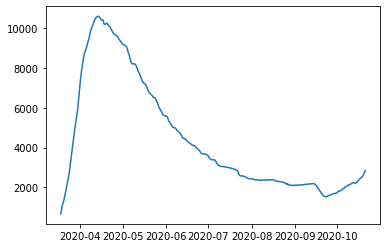

In [19]:

plt.figure(1)
plt.plot([datetime.strptime(d, '%Y-%m-%d') for d in days],beds_real["total"])


In [20]:
mult_deaths = np.sum(data[data['reg']==11][data['cl_age90']==0].hosp.values)/np.sum(data[data['reg']==11][data['cl_age90']==0].dc.values)
print(mult_deaths)
mult_icus = np.sum(data[data['reg']==11][data['cl_age90']==0].hosp.values)/np.sum(data[data['reg']==11][data['cl_age90']==0].rea.values)
print(mult_icus)


0.7791072263244828
7.194862933913178


/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
region = "Ile-de-France"

In [22]:
# Read group parameters
with open("../parameters/"+region+".yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    universe_params = yaml.load(file, Loader=yaml.FullLoader)
    
# Read initialization
with open("../initialization/patient_zero.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    original_initialization = yaml.load(file, Loader=yaml.FullLoader)

# Read econ parameters
with open("../parameters/econ.yaml") as file:
    econ_params = yaml.load(file, Loader=yaml.FullLoader)

experiment_params = {
    'delta_schooling':0.5,
    'xi':0,
    'icus':3000,
}

In [23]:
date_1 = datetime.strptime("2020-03-17", '%Y-%m-%d')
date_2 = datetime.strptime("2020-05-11", '%Y-%m-%d')
date_3 = datetime.strptime("2020-06-01", '%Y-%m-%d')
date_4 = datetime.strptime("2020-07-01", '%Y-%m-%d')
date_5 = datetime.strptime("2020-09-01", '%Y-%m-%d')
final_date = datetime.strptime("2020-10-21", '%Y-%m-%d')

vacation_start = datetime.strptime("2020-04-01", '%Y-%m-%d')
vacation_end = date_5
days_vacation_start = (vacation_start - date_1).days
days_vacation_end = (vacation_end - date_1).days

first_day_google = datetime.strptime("2020-02-15", '%Y-%m-%d')
days_between_google = (date_1-first_day_google).days

In [24]:
(final_date-date_1).days+140

358

In [25]:
from copy import deepcopy

In [26]:
original_beta = universe_params['seir-groups']["age_group_0_9"]["parameters"]["beta"]
original_beta_vacation = original_beta
#original_beta_vacation = universe_params['seir-groups']["age_group_0_9"]["parameters"]["beta_vacation"]
t_days_beta = 730

for ag in universe_params['seir-groups']:
    universe_params['seir-groups'][ag]["parameters"]["beta"] = (
        [(original_beta if (t<days_vacation_start or t>= days_vacation_end) else original_beta_vacation) for t in range(t_days_beta) ]
    )


In [27]:
# Create model
mixing_method = {}
dynModel = FastDynamicalModel(universe_params, econ_params, experiment_params, 1, mixing_method, 1e9, 0, 0)


In [28]:
initial_params

{'mu': array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]),
 'sigma': array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]),
 'p_ICU': array([0.000444, 0.000444, 0.00069 , 0.002067, 0.003774, 0.00966 ,
        0.021868, 0.028137, 0.01792 ]),
 'p_H': array([0.001556, 0.001556, 0.00531 , 0.010933, 0.013226, 0.02534 ,
        0.049132, 0.084863, 0.30208 ]),
 'lambda_H_R': array([0.0665328 , 0.0665328 , 0.06619813, 0.06566265, 0.06472557,
        0.06258367, 0.05850067, 0.05287818, 0.04578313]),
 'lambda_H_D': array([0.00040161, 0.00040161, 0.00073628, 0.00127175, 0.00220884,
        0.00435074, 0.00843373, 0.01405622, 0.02115127]),
 'lambda_ICU_R': array([0.04526412, 0.04526412, 0.04503643, 0.04467213, 0.04403461,
        0.04257741, 0.03979964, 0.0359745 , 0.03114754]),
 'lambda_ICU_D': array([0.00027322, 0.00027322, 0.00050091, 0.00086521, 0.00150273,
        0.00295993, 0.0057377 , 0.00956284, 0.0143898 ]),
 'lambda_ICU': array([0.04553734, 0.04553734, 0.04553734, 0.0

In [29]:
lower_params

{'mu': array([0.22573363, 0.22573363, 0.22573363, 0.22573363, 0.22573363,
        0.22573363, 0.22573363, 0.22573363, 0.22573363]),
 'sigma': array([0.22321429, 0.22321429, 0.22321429, 0.22321429, 0.22321429,
        0.22321429, 0.22321429, 0.22321429, 0.22321429]),
 'p_ICU': array([0.000192, 0.000192, 0.000404, 0.001168, 0.0021  , 0.005565,
        0.012516, 0.016147, 0.01007 ]),
 'p_H': array([0.000235, 0.000235, 0.00268 , 0.00454 , 0.003655, 0.005502,
        0.00702 , 0.02185 , 0.160854]),
 'lambda_H_R': array([0.06442559, 0.06442559, 0.06422977, 0.06377285, 0.06285901,
        0.06070496, 0.05665796, 0.05104439, 0.04412533]),
 'lambda_H_D': array([0.00019582, 0.00019582, 0.00045692, 0.00097911, 0.00189295,
        0.00391645, 0.0078329 , 0.01325065, 0.02016971]),
 'lambda_ICU_R': array([0.04367257, 0.04367257, 0.04353982, 0.04323009, 0.04261062,
        0.04115044, 0.03840708, 0.03460177, 0.0299115 ]),
 'lambda_ICU_D': array([0.00013274, 0.00013274, 0.00030973, 0.00066372, 0.00128

In [30]:
initial_params

{'mu': array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]),
 'sigma': array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]),
 'p_ICU': array([0.000444, 0.000444, 0.00069 , 0.002067, 0.003774, 0.00966 ,
        0.021868, 0.028137, 0.01792 ]),
 'p_H': array([0.001556, 0.001556, 0.00531 , 0.010933, 0.013226, 0.02534 ,
        0.049132, 0.084863, 0.30208 ]),
 'lambda_H_R': array([0.0665328 , 0.0665328 , 0.06619813, 0.06566265, 0.06472557,
        0.06258367, 0.05850067, 0.05287818, 0.04578313]),
 'lambda_H_D': array([0.00040161, 0.00040161, 0.00073628, 0.00127175, 0.00220884,
        0.00435074, 0.00843373, 0.01405622, 0.02115127]),
 'lambda_ICU_R': array([0.04526412, 0.04526412, 0.04503643, 0.04467213, 0.04403461,
        0.04257741, 0.03979964, 0.0359745 , 0.03114754]),
 'lambda_ICU_D': array([0.00027322, 0.00027322, 0.00050091, 0.00086521, 0.00150273,
        0.00295993, 0.0057377 , 0.00956284, 0.0143898 ]),
 'lambda_ICU': array([0.04553734, 0.04553734, 0.04553734, 0.0

In [31]:
# Construct the windows for the parameters to move
windows = {}
# for p in initial_params:
#     windows[p] = (
#         np.min(upper_params[p]/initial_params[p]),
#         np.max(lower_params[p]/initial_params[p]),
#     )
    
windows['beta_mixing'] = (0.1,2.0)
windows['alpha_mixing'] = (0.1,2.0)
windows['gamma_mixing'] = (0.5,2.0)
windows['work_l'] = (0.2,0.3)
windows['other_l'] = (0,0.1)
windows['school_l'] = (0,0.1)
windows['leisure_l'] = (0,0.1)
windows['transport_l'] = (0.2,0.3)
windows['transmission'] = (0.5,2.0)

In [32]:
windows

{'beta_mixing': (0.1, 2.0),
 'alpha_mixing': (0.1, 2.0),
 'gamma_mixing': (0.5, 2.0),
 'work_l': (0.2, 0.3),
 'other_l': (0, 0.1),
 'school_l': (0, 0.1),
 'leisure_l': (0, 0.1),
 'transport_l': (0.2, 0.3),
 'transmission': (0.5, 2.0)}

In [33]:
# Generate samples
np.random.seed(0)
n_samples = 1
samples = 1+np.random.randn(n_samples,(final_date-date_1).days+150, 5)*0.05/2/np.sqrt(3)

In [34]:
import copy
import math
import matplotlib.dates as mdates
best_v = 0
best_error = float('inf')
validation_date = datetime.strptime("2020-10-21", '%Y-%m-%d')
icu_bound = 2950

def error(v):
    
    vector_upper_model_data_beds = []
    vector_upper_model_data_deaths = []
    vector_upper_model_data_icus = []
    vector_errors = []
    vector_deaths = []
    
    for n_sample in range(n_samples):
        days_ahead = v[0]
        alpha_mixing_home = v[1]
        alpha_mixing_work = v[1]
        alpha_mixing_transport = v[1]
        alpha_mixing_school = v[1]
        alpha_mixing_other = v[1]
        alpha_mixing_leisure = v[1]
        
        mix_1 = v[3]
        mix_2 = v[4]
        
        alphas_d = {
            'work':alpha_mixing_work,
            'transport':alpha_mixing_transport,
            'school':alpha_mixing_school,
            'other':alpha_mixing_other,
            'leisure':alpha_mixing_leisure,
            'home':alpha_mixing_home,
        }

        gamma_mixing_before = 1.0
        gamma_mixing_after = 1.0


        upper_bound_home = 1.0
        upper_bound_leisure = 1.0
        upper_bound_other = 1.0
        upper_bound_school = 1.0
        upper_bound_work = 1.0
        upper_bound_transport = 1.0

        school_lockdown = v[5]
        school_may = v[6]
        school_jun_jul_aug = v[7]
        school_sep_oct = v[8]

        beta_normal = original_beta
        beta_vacation = beta_normal*v[2]

        days_change_model = 0

        #         split_H_ICU_bef = v[9]
        #         change_lambda_H_bef = v[10]
        #         change_lambda_ICU_bef = v[11]
        #         change_p_death_bef = v[12]
        
        fraction_p_ICU = v[9]
        change_lambda_H_aft = v[10]
        change_lambda_ICU_aft = v[11]
        change_p_death_aft = v[12]
        

        
        days_change_rates = v[13]
        
        #         dynModel.sigma = initial_params["sigma"]*v[10]

        #         dynModel.lambda_H_R = initial_params["lambda_H_R"]*v[13]
        
        #         dynModel.lambda_ICU_R = initial_params["lambda_ICU_R"]*v[15]




        google['other'] = mix_1*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+(1-mix_1)*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
        google['leisure'] = mix_2*(google["parks_percent_change_from_baseline"]+100)/100+(1-mix_2)*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100


        # Number of days
        days_before_date_1 = int(days_ahead)
        days_between_dates_1_2 = (date_2-date_1).days
        days_between_dates_2_3 = (date_3-date_2).days
        days_between_dates_3_4 = (date_4-date_3).days
        days_between_dates_4_5 = (date_5-date_4).days
        days_after_date_5 = (final_date-date_5).days
        total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5+ days_after_date_5
        days_denom = days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4+days_between_dates_4_5


        # Some additional calculations
        validation_days = days_before_date_1 + (validation_date-date_1).days
        vacation_start_days = days_before_date_1 + (vacation_start-date_1).days
        vacation_end_days = days_before_date_1 + (vacation_end-date_1).days


        # Construct initialization
        initialization = copy.deepcopy(original_initialization)
        for i,group in enumerate(age_groups):
            if group == "age_group_40_49":
                initialization[group]["I"] = initialization[group]["I"] + 1
                initialization[group]["S"] = initialization[group]["S"] - 1
            initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]


        # Alphas
        a_before_google = {
            'home':upper_bound_home,
            'leisure':upper_bound_leisure,
            'other':upper_bound_other,
            'school':upper_bound_school,
            'transport':upper_bound_transport,
            'work':upper_bound_work
        }



        # Determine mixing method
        #     mixing_method_before = {
        #         "name":"mult",
        #         "param_alpha":alpha_mixing_before,
        #         "param_beta":alpha_mixing_before,
        #     }

        #     # Determine mixing method
        #     mixing_method_after = {
        #         "name":"mult",
        #         "param_alpha":alpha_mixing_after,
        #         "param_beta":alpha_mixing_after,
        #     }
        #dynModel.mixing_method = mixing_method_after




        # Calculate alphas
        alphas_vec = []
        for t in range(days_before_date_1-days_between_google):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = a_before_google
            alphas_vec.append(alphas)

        counter = 0
        for t in range(days_between_google):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':1.0,
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_1_2):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_lockdown*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_2_3):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_may*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_3_4):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_may*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_4_5):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_jun_jul_aug*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_after_date_5):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_sep_oct*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)
            counter += 1




        #     mixing_vec = []
        #     for t in range(int(vacation_start_days+days_change_model)):
        #         mixing_vec.append(mixing_method_before)
        #     for t in range(int(vacation_start_days+days_change_model),total_days):
        #         mixing_vec.append(mixing_method_after)




        # Calculate tests
        tests = np.zeros(len(age_groups))


        # Run model
        model_data_beds = {ag:[] for ag in age_groups+["total"]}
        model_data_icus = {ag:[] for ag in age_groups+["total"]}
        model_data_deaths = {ag:[] for ag in age_groups+["total"]}

        state = state_to_matrix(initialization)
        t_beds = 0
        t_icus = 0
        t_deaths = 0
        for i,ag in enumerate(age_groups):
            state_H = state[i,cont.index("H")]
            state_ICU = state[i,cont.index("ICU")]
            state_D = state[i,cont.index("D")]
            model_data_beds[ag].append(state_H)
            model_data_icus[ag].append(state_ICU)
            model_data_deaths[ag].append(state_D)
            t_beds+= state_H
            t_icus+= state_ICU
            t_deaths+= state_D
        model_data_beds["total"].append(t_beds)
        model_data_icus["total"].append(t_icus)
        model_data_deaths["total"].append(t_deaths)

        recalc_days = [0,
                     days_before_date_1,
                     days_before_date_1+days_between_dates_1_2,
                     days_before_date_1+days_between_dates_1_2+days_between_dates_2_3,
                     days_before_date_1+days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4,
                     days_before_date_1+days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4+days_between_dates_4_5,
                    int(vacation_start_days)
                    ]

        dynModel.beta = np.zeros((len(age_groups),len(dynModel.groups[age_groups[0]].parameters["beta"])))
        for i in range(len(age_groups)):
            for j in range(len(dynModel.groups[age_groups[0]].parameters["beta"])):
                if j < int(vacation_start_days+days_change_model):
                    dynModel.beta[i,j] = beta_normal
                else:
                    dynModel.beta[i,j] = beta_vacation

        for t in range(total_days):
            current_date = date_1+timedelta(days=t-days_before_date_1)
            day_of_week = current_date.weekday()

            if t in recalc_days:
                update_contacts = True
            else:
                update_contacts = True
                
            if t<int(vacation_start_days+days_change_rates):
                dynModel.p_H = initial_params["p_H"]
                dynModel.p_ICU = initial_params["p_ICU"]

                lambda_H = initial_params["lambda_H"]
                lambda_ICU = initial_params["lambda_ICU"]
                p_death = initial_params["p_death"]
                
                dynModel.lambda_H_D = p_death*lambda_H
                dynModel.lambda_H_R = (1-p_death)*lambda_H
                dynModel.lambda_ICU_D = p_death*lambda_ICU
                dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU

            else:
                trans_days = 60.0
                d_after = t-int(vacation_start_days+days_change_rates)
                d_portion = max(trans_days-d_after,0)/trans_days
                
                dynModel.p_ICU = initial_params["p_H"]*d_portion+initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion)
                dynModel.p_H = initial_params["p_ICU"]*d_portion+(initial_params["p_H"]+initial_params["p_ICU"])-initial_params["p_ICU"]*fraction_p_ICU*(1-d_portion)
                

                lambda_H = initial_params["lambda_H"]*d_portion+initial_params["lambda_H"]*change_lambda_H_aft*(1-d_portion)
                lambda_ICU = initial_params["lambda_ICU"]*d_portion+ initial_params["lambda_ICU"]*change_lambda_ICU_aft*(1-d_portion)
                p_death = initial_params["p_death"]*d_portion+initial_params["p_death"]*change_p_death_aft*(1-d_portion)
                
                dynModel.lambda_H_D = p_death*lambda_H
                dynModel.lambda_H_R = (1-p_death)*lambda_H
                dynModel.lambda_ICU_D = p_death*lambda_ICU
                dynModel.lambda_ICU_R = (1-p_death)*lambda_ICU
            

            if day_of_week <= 4:
                season = "new"
                dynModel.mixing_method = {
                    "name":"mult",
                    "param_alpha":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                    "param_beta":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                }
            else:
                season = "new"
                dynModel.mixing_method = {
                    "name":"mult",
                    "param_alpha":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                    "param_beta":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                }

            #dynModel.mixing_method = mixing_vec[t]

            state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]), t, season, update_contacts=update_contacts)
            t_beds = 0
            t_icus = 0
            t_deaths = 0
            for i,ag in enumerate(age_groups):
                state_H = state[i,cont.index("H")]
                state_ICU = state[i,cont.index("ICU")]
                state_D = state[i,cont.index("D")]
                model_data_beds[ag].append(state_H)
                model_data_icus[ag].append(state_ICU)
                model_data_deaths[ag].append(state_D)
                t_beds+= state_H
                t_icus+= state_ICU
                t_deaths+= state_D
            #print(t_beds)
            model_data_beds["total"].append(t_beds)
            model_data_icus["total"].append(t_icus)
            model_data_deaths["total"].append(t_deaths)


        initial_date = date_1-timedelta(days=days_before_date_1)

        # Calculate the days of the model
        days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

        # Indices where to put the real data
        indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

        # Real data
        real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
        real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
        real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}

        for k,ind in enumerate(indices):
            for ag in age_groups+["total"]:
                real_data_beds[ag][ind] = beds_real[ag][k] if beds_real[ag][k]!=0 else float('nan')
                real_data_icus[ag][ind] = icus_real[ag][k] if icus_real[ag][k]!=0 else float('nan')
                real_data_deaths[ag][ind] = deaths_real[ag][k] if deaths_real[ag][k]!=0 else float('nan')


        error_constant = 0.25
        error_beds = 0
        error_icus = 0
        error_deaths = 0
        error_beds_total = 0
        error_icus_total = 0
        error_deaths_total = 0
        
        peak_beds = np.nanargmax(np.array(real_data_beds["total"]))
        peak_icus = np.nanargmax(np.array(real_data_icus["total"]))
        peak_deaths = peak_beds+30
        
        for ag in old_age_groups:
            error_beds += np.nanmean((np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag]))/np.array(real_data_beds[ag]))[0:validation_days-1])
            error_icus += np.nanmean((np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag]))/np.array(real_data_icus[ag]))[0:validation_days-1])
            error_deaths += np.nanmean((np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag]))/np.array(real_data_deaths[ag]))[0:validation_days-1])
        error_beds_total += np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[0:validation_days-1])
        error_beds_total += error_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[validation_days-1:validation_days])
        error_beds_total += error_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[peak_beds:peak_beds+1])
                              
        error_icus_total += np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[0:validation_days-1])
        error_icus_total += error_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[validation_days-1:validation_days])
        error_icus_total += error_constant*np.nanmean((np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"]))/np.array(real_data_icus["total"]))[peak_icus:peak_icus+1])

                              
        error_deaths_total += np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[0:validation_days-1])
        error_deaths_total += error_constant*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[validation_days-1:validation_days])
        error_deaths_total += error_constant/2.0*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_deaths:peak_deaths+1])
        error_deaths_total += error_constant/2.0*np.nanmean((np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"]))/np.array(real_data_deaths["total"]))[peak_beds:peak_beds+1])

        overflow = np.array(model_data_icus["total"]) - icu_bound
        overflow_error = np.nanmean([max(overflow[i],0) for i in range(len(overflow))])


        #diff = np.array(model_data_beds["total"])-np.array(real_data_beds["total"])
        #error_beds_above = np.nanmean([max(d,0) for d in diff])
        #error_beds_below = -np.nanmean([min(d,0) for d in diff])

        #cumm_beds_model = [sum([model_data_beds["total"][k] for k in range(i+1) if not math.isnan(real_data_beds["total"][k])]) for i in range(len(model_data_beds["total"]))]
        #cumm_beds_real = [sum([real_data_beds["total"][k] for k in range(i+1) if not math.isnan(real_data_beds["total"][k])]) for i in range(len(real_data_beds["total"]))]
        #diff_cumm = np.array(cumm_beds_model)-np.array(cumm_beds_real)
        #error_cumm_above = np.nanmean([max(d,0) for d in diff_cumm])
        #error_cumm_below = -np.nanmean([min(d,0) for d in diff_cumm])



        #     error = error_beds_total
        #     error = mult_icus*error_icus_total
        #     error = mult_deaths*error_deaths_total
        upper_days_model = days_model
        
        error = 0.25*error_beds+4*error_beds_total+0.25*error_icus+4*error_icus_total+0.25*error_deaths+4*error_deaths_total+overflow_error

        vector_errors.append(error)
        vector_deaths.append(error_deaths)
        vector_upper_model_data_beds.append(model_data_beds["total"])
        vector_upper_model_data_deaths.append(model_data_deaths["total"])
        vector_upper_model_data_icus.append(model_data_icus["total"])
        

    error = np.mean(vector_errors)

    
    global best_error
    global best_v
    if error<best_error:
        best_error = error
        print("best_error:",best_error)
        print("vector:",vector_errors)
        print("mean_deaths",np.mean(vector_deaths))
        best_v = v
        print(v)

        print("Beds")
        plt.figure(1)
        for n_sample in range(n_samples):
            plt.plot(upper_days_model, vector_upper_model_data_beds[n_sample], label="Prediction")
        plt.plot(upper_days_model, real_data_beds["total"], label="Real")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        plt.show()
        
        print("Deaths")
        plt.figure(1)
        for n_sample in range(n_samples):
            plt.plot(upper_days_model, vector_upper_model_data_deaths[n_sample], label="Prediction")
        plt.plot(upper_days_model, real_data_deaths["total"], label="Real")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        plt.show()
        
        print("ICUs")
        plt.figure(1)
        for n_sample in range(n_samples):
            plt.plot(upper_days_model, vector_upper_model_data_icus[n_sample], label="Prediction")
        plt.plot(upper_days_model, real_data_icus["total"], label="Real")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        plt.show()
        
        

    return error





/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


best_error: 193.1259743922414
vector: [193.1259743922414]
mean_deaths 33.531577088709625
[53.16287196  1.76947287  1.11511568  0.39893434  0.82168011  0.08702135
  0.91807194  0.13880661  0.97328852  0.59862108  1.11758437  0.61283223
  1.05740989  4.38017631]
Beds
best_error: 210.14492199931104
vector: [210.14492199931104]
mean_deaths 52.80386043448205
[5.59761114e+01 4.58831204e-01 9.84865484e-01 2.42753471e-01
 4.43496215e-02 4.11642865e-02 6.32388671e-01 2.14280586e-02
 8.59707504e-01 1.68895966e+00 7.93526148e-01 1.35858021e+00
 1.69322207e+00 2.89534175e+01]
Beds
best_error: 20.513945511653375
vector: [20.513945511653375]
mean_deaths 3.9155632052713822
[6.38436151e+01 8.68100774e-01 6.32744939e-01 4.80528802e-01
 9.28780301e-02 8.95376166e-02 3.93236132e-02 1.80113346e-01
 9.54394618e-01 1.90065964e+00 1.19996952e+00 1.46728731e+00
 1.04661505e+00 4.19865199e+01]
Beds
best_error: 250.19033244648193
vector: [250.19033244648193]
mean_deaths 120.98454016746935
best_error: 226.768224

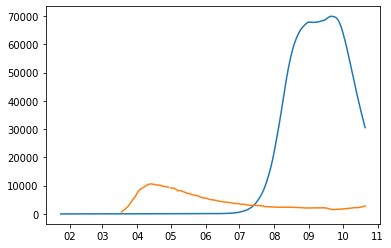

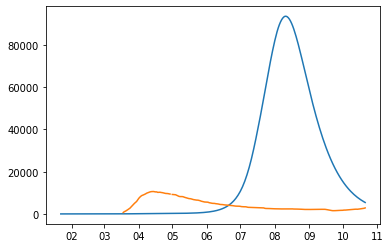

Deaths
Deaths


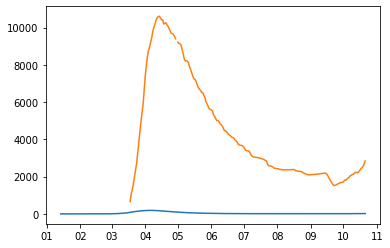

Deaths


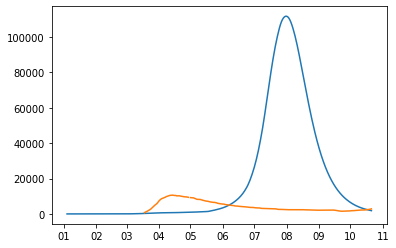

Deaths


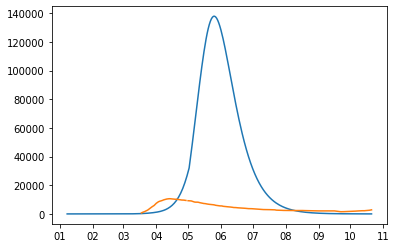

Deaths


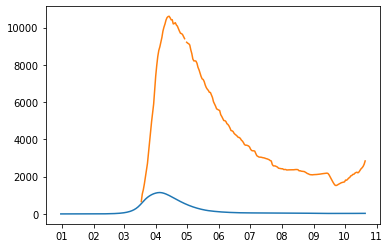

Deaths


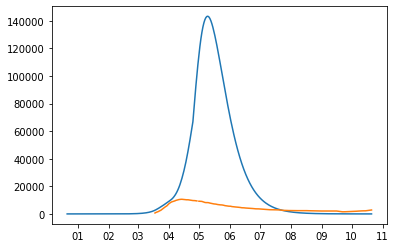

Deaths


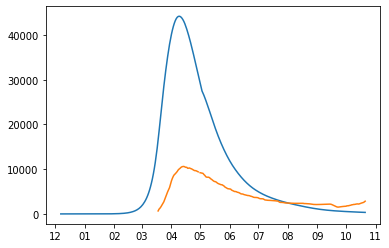

Deaths


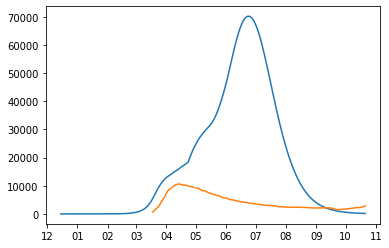

Deaths


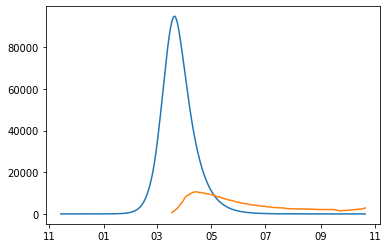

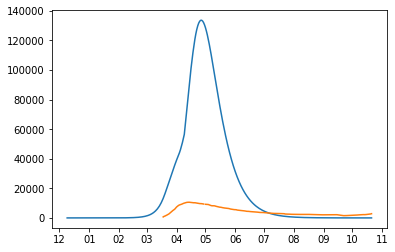

Deaths
Deaths


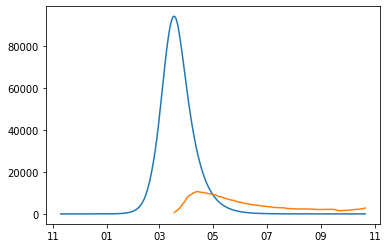

Deaths


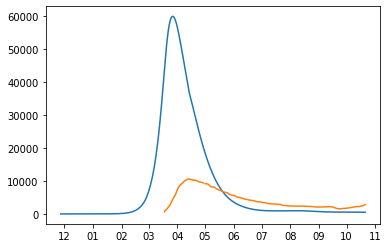

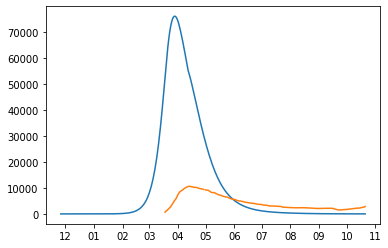

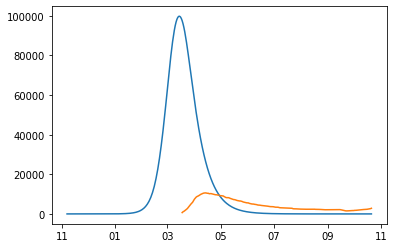

Deaths
Deaths
Deaths


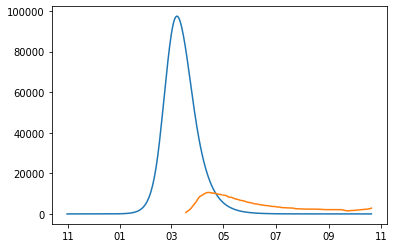

Deaths


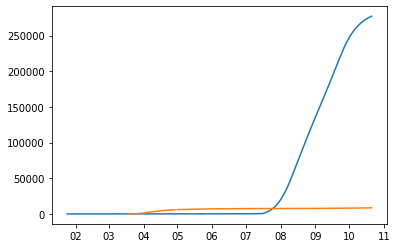

ICUs


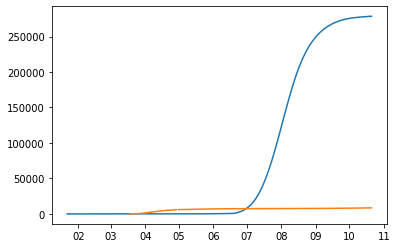

ICUs


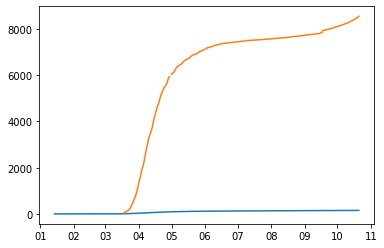

ICUs


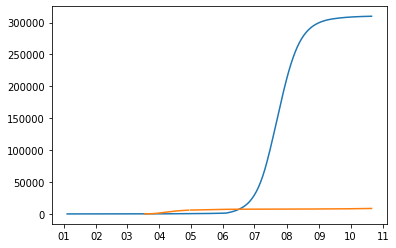

ICUs


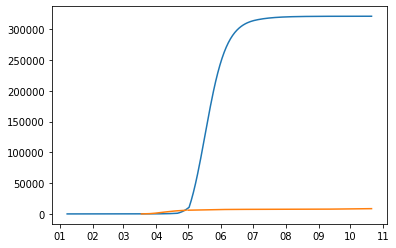

ICUs


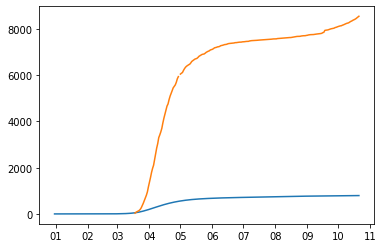

ICUs


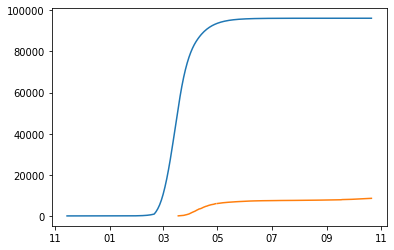

ICUs


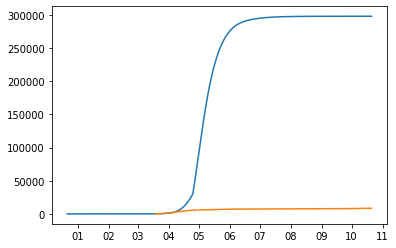

ICUs


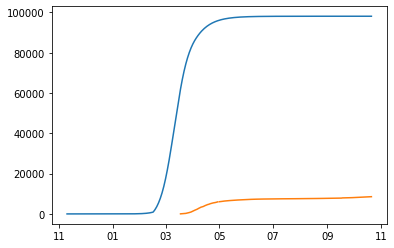

ICUs


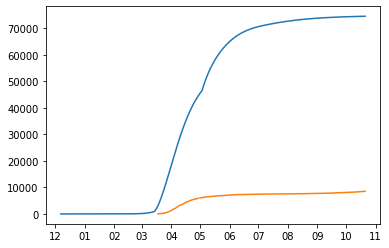

ICUs


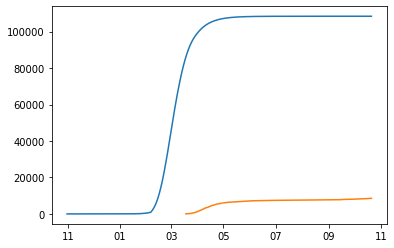

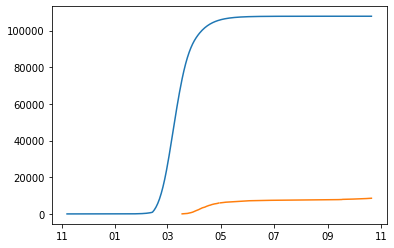

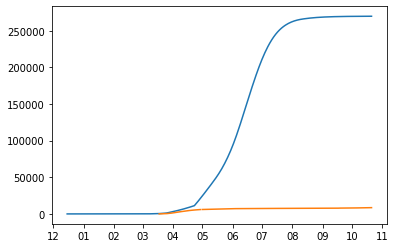

ICUs
ICUs
ICUs


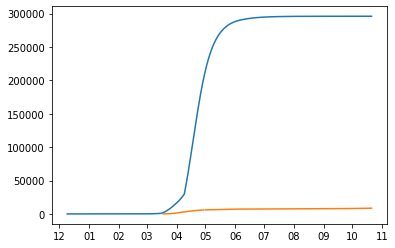

ICUs


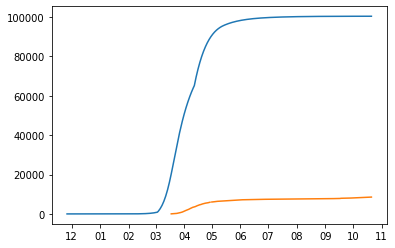

ICUs


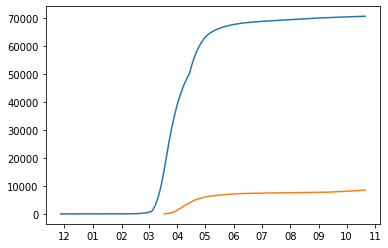

ICUs


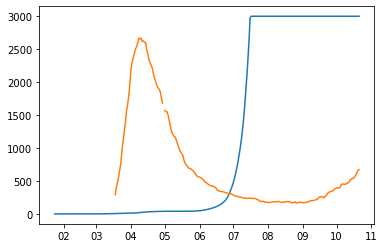

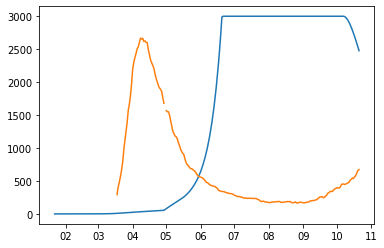

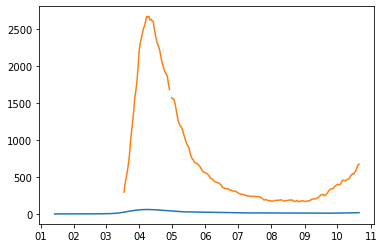

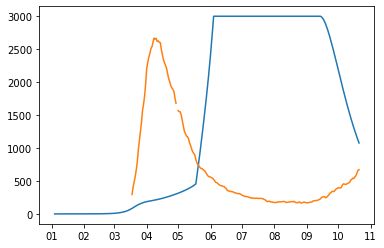

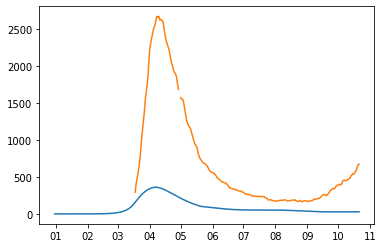

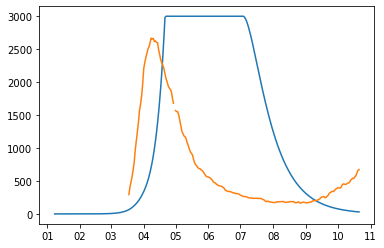

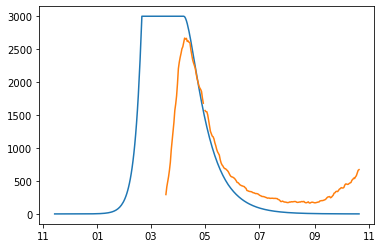

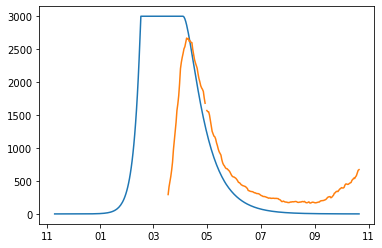

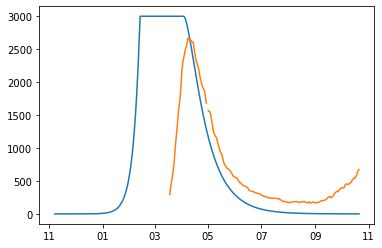

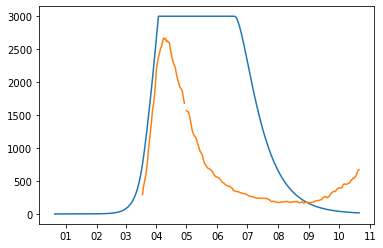

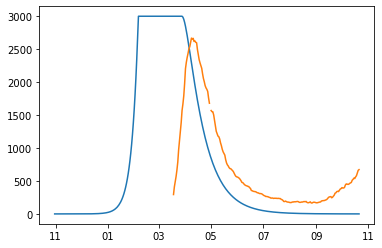

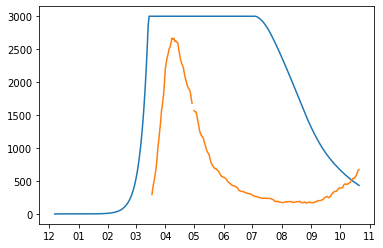

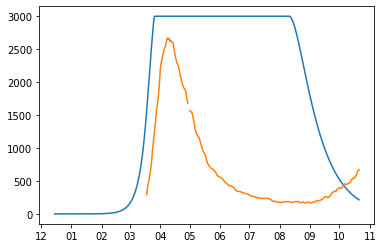

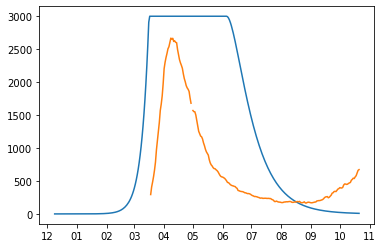

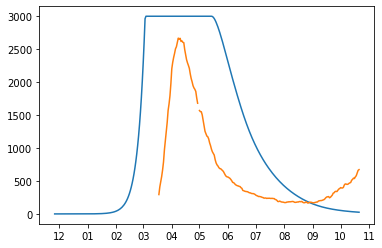

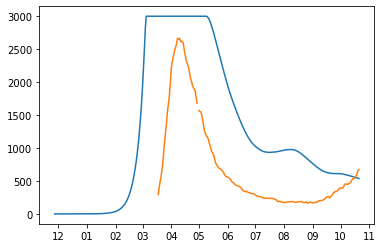

best_error: 20.75836588757781
vector: [20.75836588757781]
mean_deaths 3.9342052265788263
[6.36256826e+01 1.70866091e+00 5.44794404e-01 8.71628604e-02
 1.79725103e-01 3.34588465e-02 9.56565482e-01 5.77074203e-02
 5.59396227e-01 1.21475416e+00 1.92221149e+00 1.63052467e+00
 1.44305738e+00 3.22720710e+01]
Beds
best_error: 276.14666471399045
vector: [276.14666471399045]
mean_deaths 102.5236780728251
[5.43676581e+01 5.87045128e-01 1.39296696e+00 8.12294114e-02
 5.20356619e-01 6.15832725e-02 2.32131316e-01 1.94179530e-02
 8.73814194e-01 1.72326660e+00 1.69862250e+00 7.52030234e-01
 1.52880252e+00 2.08010013e+01]
Beds
best_error: 191.73049098408933
vector: [191.73049098408933]
mean_deaths 48.030636449738694
[9.19701266e+01 9.50426392e-01 1.10748502e+00 3.03688412e-01
 1.63480175e-01 1.07562866e-02 3.31249533e-01 1.94442317e-01
 9.55085157e-01 5.40580931e-01 1.59960259e+00 1.22299738e+00
 1.73074796e+00 4.71389696e+00]
Beds
best_error: 19.75733215526683
vector: [19.75733215526683]
mean_deaths 

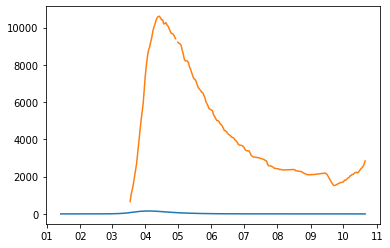

Deaths
best_error: 216.15285592491517
vector: [216.15285592491517]
mean_deaths 182.29052992041824
[1.19550258e+02 1.25681428e+00 1.24371204e+00 4.38644196e-01
 7.90617018e-01 6.39192743e-02 8.41143074e-01 9.32420296e-02
 6.68374251e-01 1.33739177e+00 7.37921783e-01 5.54729816e-01
 1.84632973e+00 5.37738567e+01]
Beds
best_error: 185.16351756076537
vector: [185.16351756076537]
mean_deaths 113.18391086372394
[1.08035001e+02 2.97231813e-01 1.37296911e+00 2.62347939e-01
 2.27302716e-01 7.19976452e-02 6.74359203e-01 4.92472296e-02
 5.25795083e-01 1.86130338e+00 5.26308513e-01 6.20817135e-01
 1.20311507e+00 2.37557187e+01]
Beds


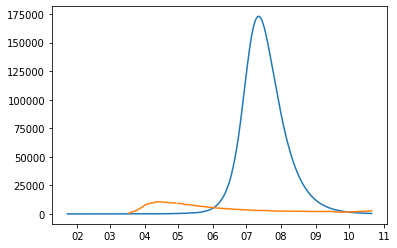

Deaths


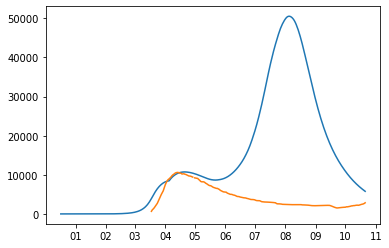

Deaths


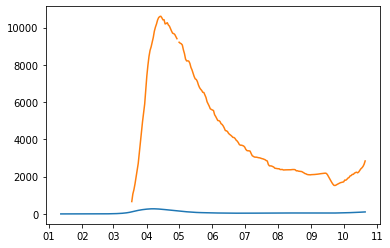

Deaths


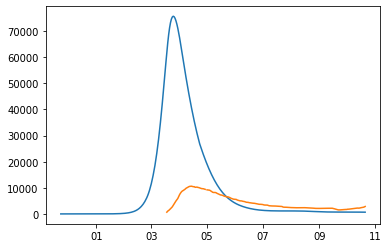

Deaths


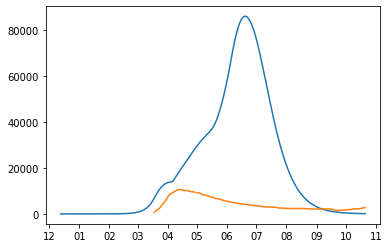

Deaths


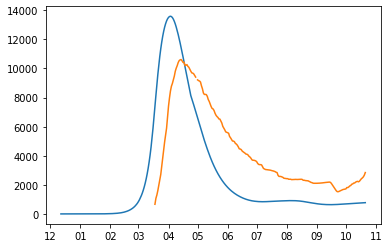

Deaths


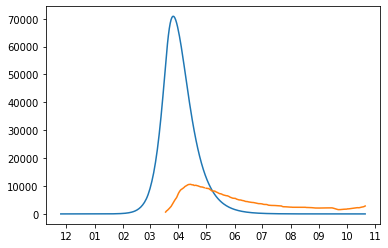

Deaths


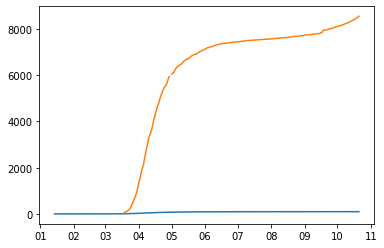

ICUs


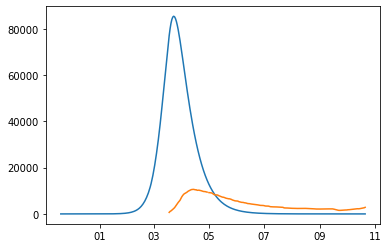

Deaths


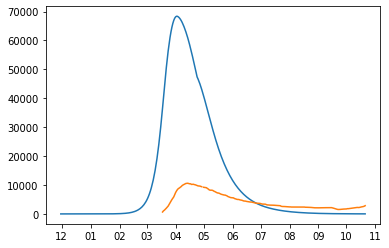

Deaths


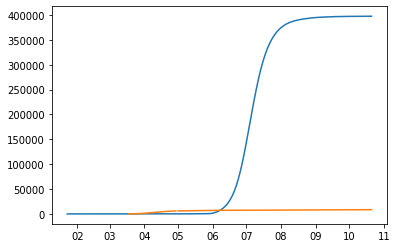

ICUs


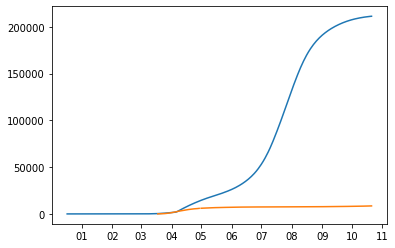

ICUs


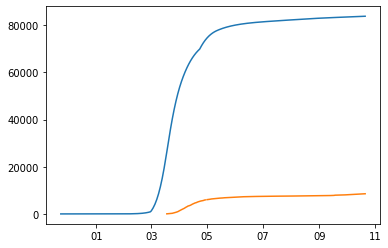

ICUs


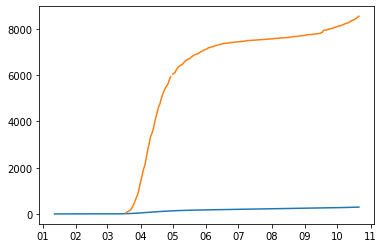

ICUs


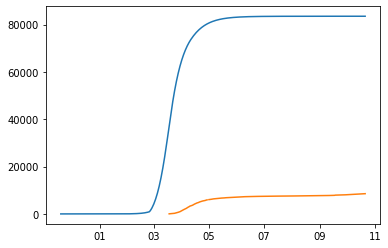

ICUs


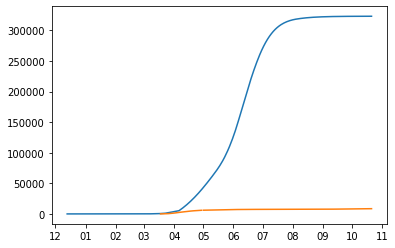

ICUs


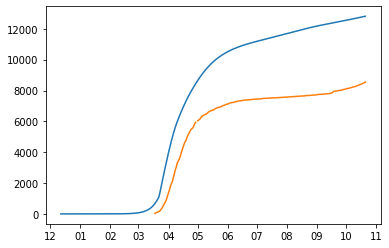

ICUs


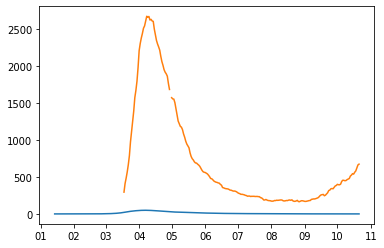

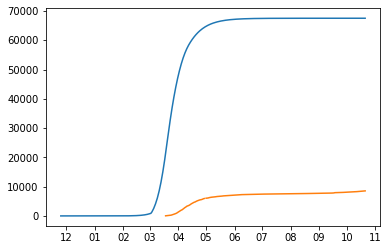

ICUs


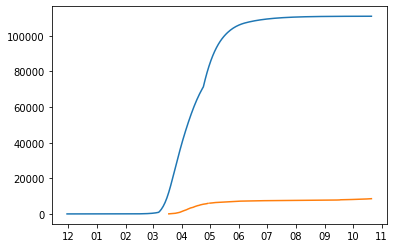

ICUs


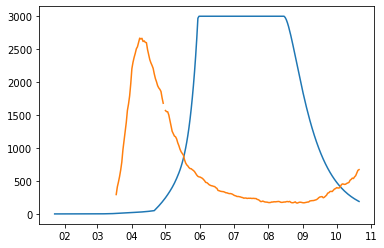

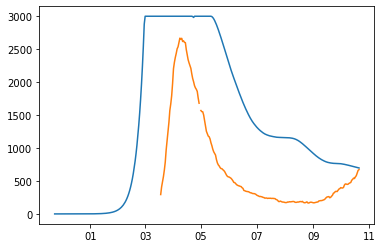

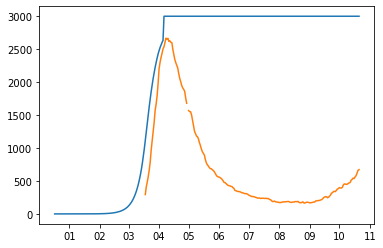

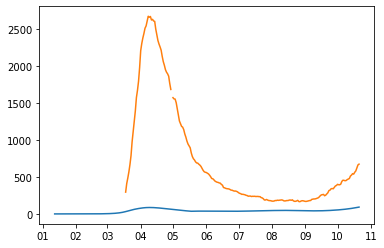

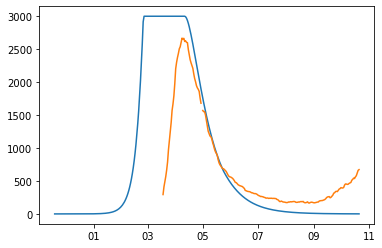

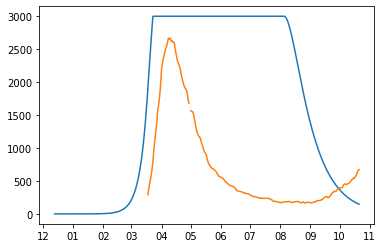

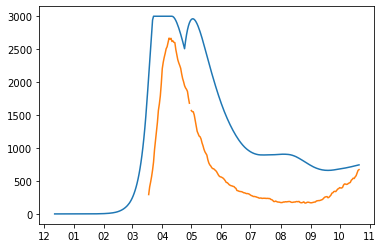

best_error: 18.44363062251903
vector: [18.44363062251903]
mean_deaths 3.952196205101617
[52.58197765  1.9708788   0.82998243  0.11649963  0.7886509   0.05916046
  0.39573866  0.06263653  0.92724133  0.93869262  1.70612132  1.85178685
  1.14496342 48.90778721]

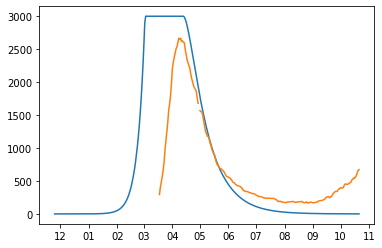


Beds


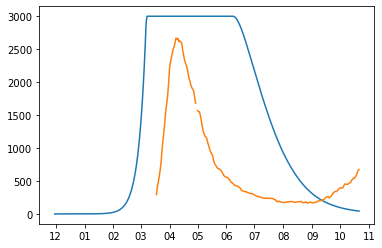

best_error: 12.104771145326122
vector: [12.104771145326122]
mean_deaths 1.9076316392132762
[9.48100226e+01 1.83299581e+00 7.13271276e-01 3.87899285e-01
 3.06867282e-01 7.81914978e-02 9.45138262e-01 3.23151822e-02
 8.00790653e-01 1.74830131e+00 8.88663932e-01 1.74198295e+00
 1.05696954e+00 3.26595253e+01]
Beds


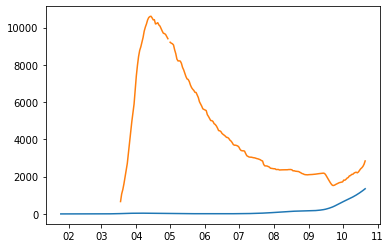

Deaths
best_error: 234.99222351633372
vector: [234.99222351633372]
mean_deaths 197.64434931849004
[1.19940650e+02 4.38638648e-01 9.54485123e-01 8.31676517e-01
 7.71028080e-01 3.84211519e-02 7.05798689e-01 3.48279901e-03
 6.44170024e-01 9.84518489e-01 5.58688422e-01 1.45946680e+00
 1.68872862e+00 5.29008143e+01]
Beds


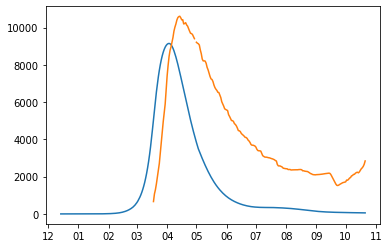

Deaths


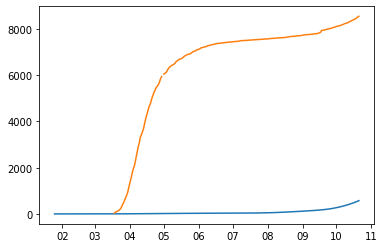

ICUs


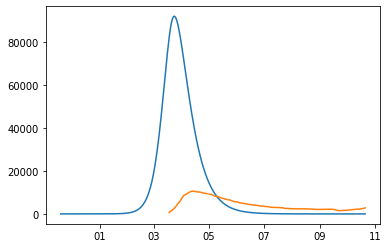

Deaths


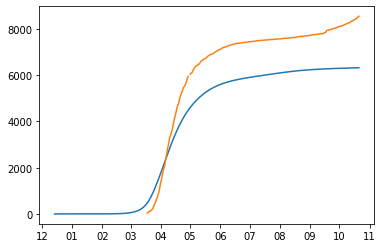

ICUs


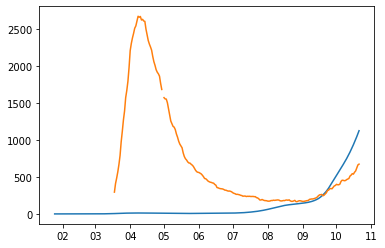

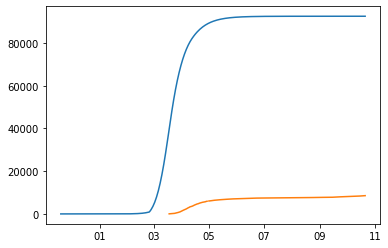

ICUs


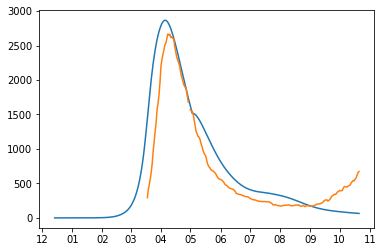

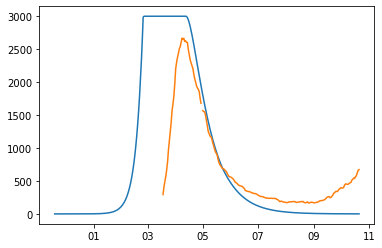

best_error: 176.38495341187038
vector: [176.38495341187038]
mean_deaths 55.47889051458315
[8.19474591e+01 2.05091926e-01 7.38489923e-01 9.28315052e-01
 6.43544040e-01 7.83251531e-03 8.63733684e-01 1.27436137e-01
 7.88294524e-01 1.87708138e+00 1.99800780e+00 1.49106455e+00
 1.00897673e+00 1.89493323e+01]
Beds
best_error: 72.42594497774797
vector: [72.42594497774797]
mean_deaths 3.684465951656147
[7.87055705e+01 8.81794190e-01 7.21335661e-01 1.37063696e-03
 4.30852483e-01 6.58045383e-02 8.80707805e-01 5.20179686e-02
 8.53970524e-01 1.86828013e+00 1.23323922e+00 1.24914516e+00
 9.71172150e-01 3.69052479e+01]
Beds
best_error: 231.39591903262914
vector: [231.39591903262914]
mean_deaths 98.0019731473239
[60.75478026  0.17811556  1.15735081  0.9356327   0.5847104   0.0625396
  0.10944192  0.14342849  0.62638256  1.17292293  1.90690158  1.29183824
  1.88611143 56.13441582]
Beds
best_error: 254.5984457691449
vector: [254.5984457691449]
mean_deaths 215.0404020685209
[1.22566393e+02 1.48504664e+0

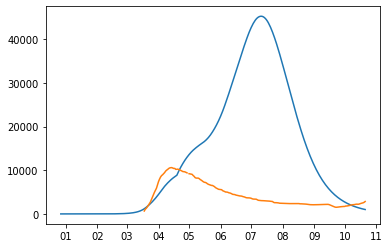

Deaths


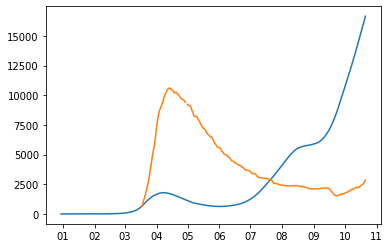

Deaths


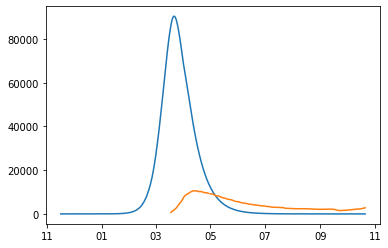

Deaths


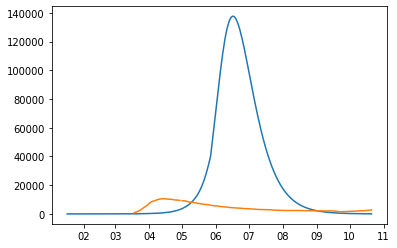

Deaths


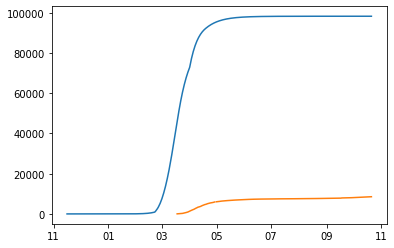

ICUs


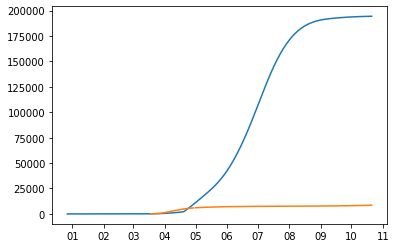

ICUs


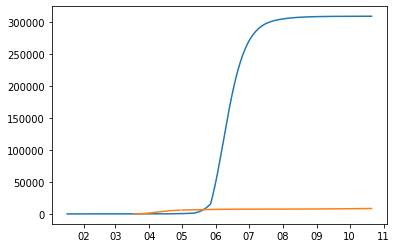

ICUs


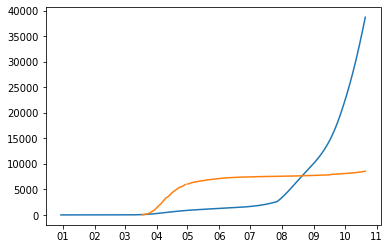

ICUs


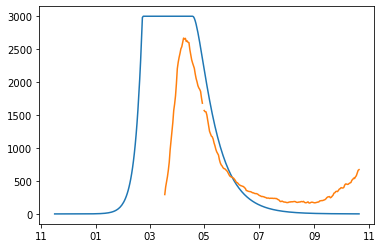

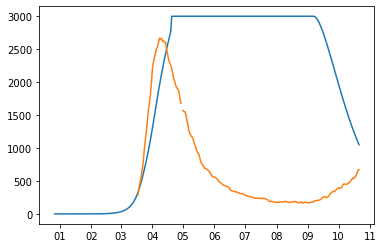

best_error: 126.32417500436878
vector: [126.32417500436878]
mean_deaths 95.43873571094002
[1.11966178e+02 1.46967942e+00 1.06384340e+00 7.36024978e-01
 9.48297487e-01 4.79774158e-02 9.08021973e-01 1.70719196e-01
 6.39129292e-01 1.55403971e+00 1.44310657e+00 1.32021431e+00
 1.18769333e+00 3.78561257e+01]
Beds


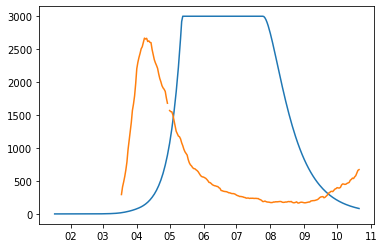

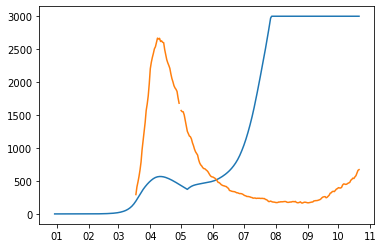

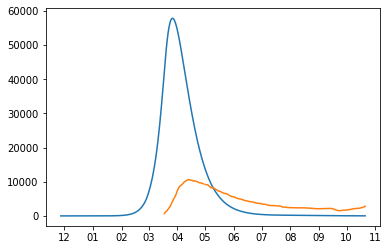

Deaths
best_error: 60.806338959866274
vector: [60.806338959866274]
mean_deaths 2.276201341341826
[8.62988778e+01 8.70525136e-01 8.15715505e-01 5.35904241e-01
 2.19070050e-02 8.25034097e-02 2.27494586e-01 1.83806555e-01
 5.40466262e-01 1.50301746e+00 1.29790561e+00 1.53311442e+00
 1.80179336e+00 2.19499605e+01]
Beds


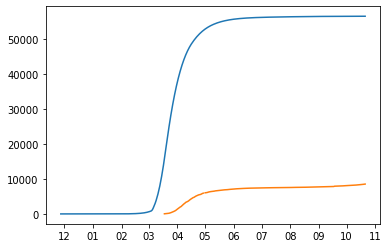

ICUs
best_error: 131.24233891689173
vector: [131.24233891689173]
mean_deaths 39.72698709894768
[1.04290845e+02 1.41320109e+00 1.18575147e+00 3.75111422e-01
 2.62815113e-01 9.16895488e-02 8.49369099e-01 1.87486359e-01
 7.64962043e-01 1.89949590e+00 9.74531726e-01 1.82300715e+00
 1.63390073e+00 4.42265909e+01]
Beds


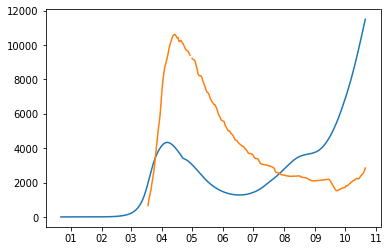

Deaths


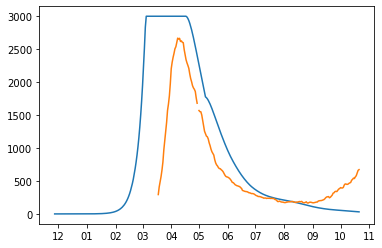

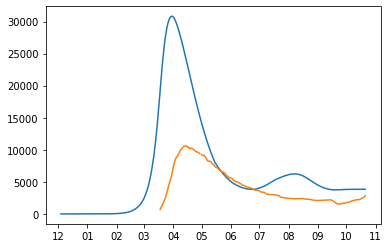

Deaths


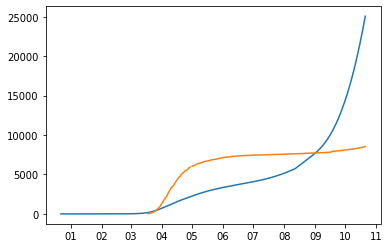

ICUs


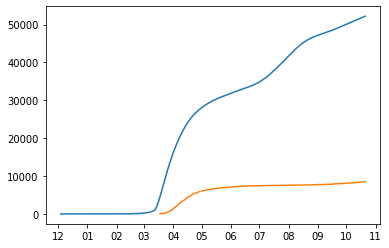

ICUs
best_error: 207.6754644604227
vector: [207.6754644604227]
mean_deaths 61.315991885690885
[8.75688209e+01 1.72565951e+00 1.45662056e+00 7.49435525e-01
 2.99856719e-01 6.71632090e-02 4.84243471e-01 6.78687414e-02
 6.87427559e-01 1.07652140e+00 7.71731342e-01 6.61360153e-01
 1.19449013e+00 4.93921610e+01]
Beds
best_error: 201.6412623623366
vector: [201.6412623623366]
mean_deaths 69.92180866252848
[9.86436441e+01 1.42557375e+00 1.81434059e+00 6.15836926e-01
 9.90144222e-02 7.97373357e-02 1.71283726e-01 1.24887339e-01
 5.94773557e-01 5.17591152e-01 5.70993417e-01 1.61745109e+00
 1.95329165e+00 4.20116097e+01]
Beds


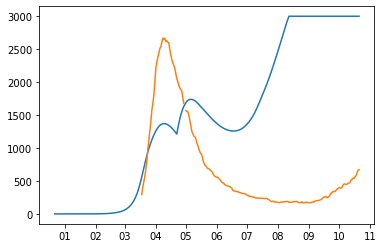

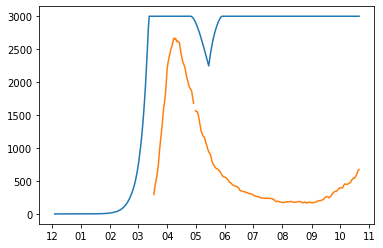

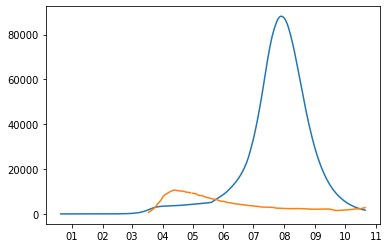

Deaths


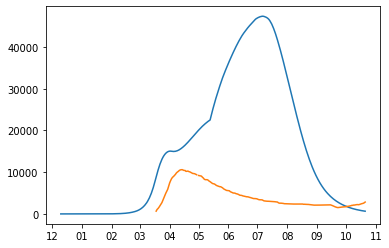

Deaths
best_error: 19.739728883027965
vector: [19.739728883027965]
mean_deaths 3.949194299238321
[59.76112505  1.92261317  0.76511752  0.91078631  0.87951364  0.09226358
  0.54816263  0.11630084  0.52878486  0.84104641  1.03472998  1.65500868
  1.02272998 45.0250904 ]
Beds
best_error: 18.59220448536135
vector: [18.59220448536135]
mean_deaths 1.3916712569001026
[9.02643682e+01 4.63135172e-01 5.63965186e-01 7.07936926e-01
 7.62438482e-01 4.37659524e-03 4.22516942e-01 8.44335917e-02
 9.16581405e-01 1.20529849e+00 6.80779942e-01 1.11721842e+00
 1.61906367e+00 3.82584054e+01]
Beds


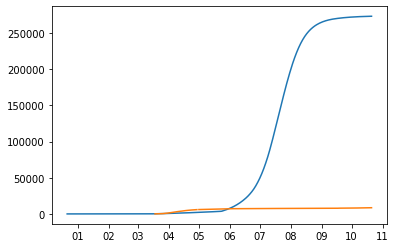

ICUs


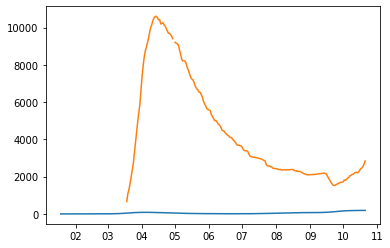

Deaths


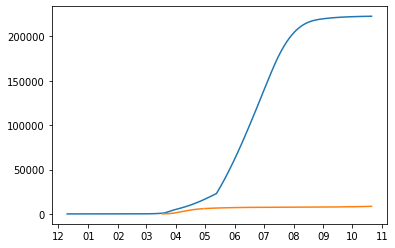

ICUs


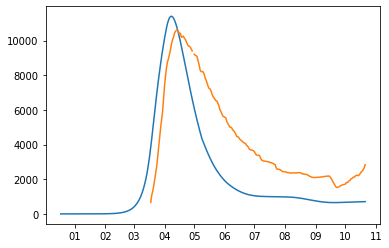

Deaths


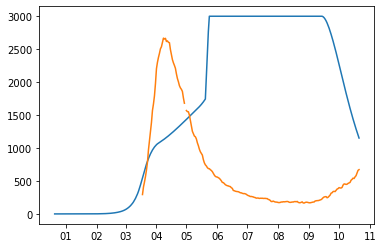

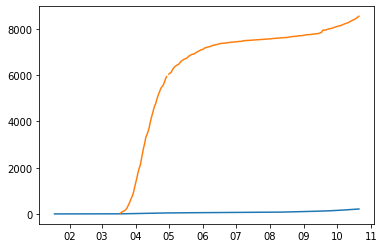

ICUs


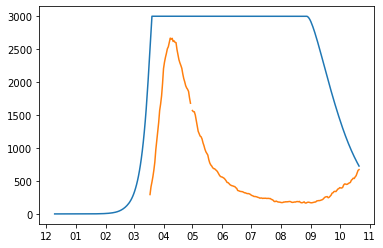

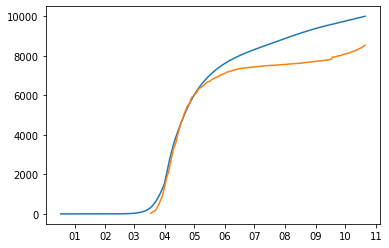

ICUs


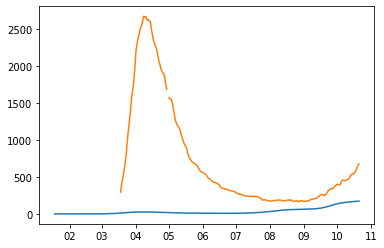

best_error: 41.00538264574752
vector: [41.00538264574752]
mean_deaths 7.595014873178492
[9.32263469e+01 4.43880188e-01 6.27474473e-01 6.86205089e-01
 2.85863298e-01 3.44184721e-02 1.24526698e-01 3.98100929e-02
 9.80521110e-01 1.38136384e+00 1.39634037e+00 1.86727309e+00
 1.15461877e+00 2.08930470e+01]
Beds


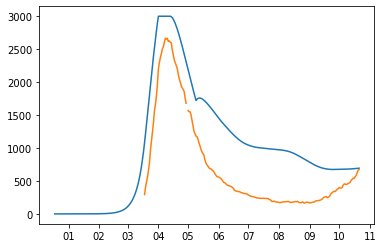

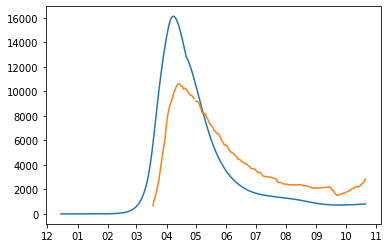

Deaths
best_error: 20.187115590866775
vector: [20.187115590866775]
mean_deaths 3.941530837764242
[5.82768126e+01 9.21322801e-01 6.46056272e-01 4.42197505e-02
 1.40163476e-01 6.91385664e-03 8.66767987e-01 2.23706910e-02
 8.16288700e-01 7.13337758e-01 9.42667991e-01 1.50131715e+00
 9.59650527e-01 1.57640236e+01]
Beds


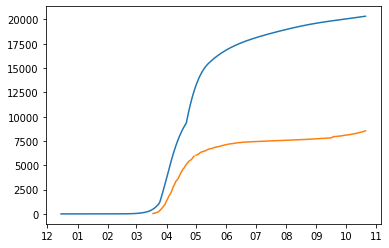

ICUs
best_error: 167.39680152921426
vector: [167.39680152921426]
mean_deaths 46.490178905372574
[8.12048759e+01 3.08757499e-01 7.89179712e-01 8.69624904e-01
 4.43549208e-01 9.61972033e-02 5.19942428e-01 5.99578877e-02
 5.81769207e-01 8.11640131e-01 1.22266618e+00 1.94896501e+00
 9.37808481e-01 4.64366970e+01]
Beds


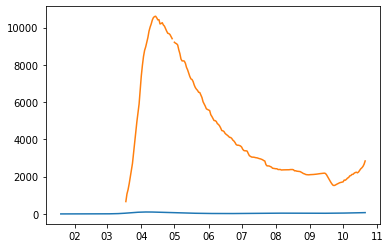

Deaths


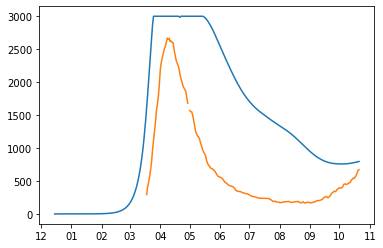

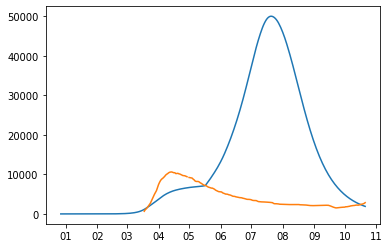

Deaths


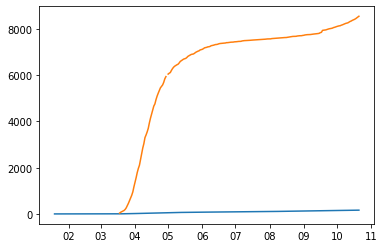

ICUs


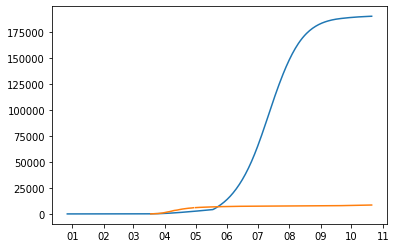

ICUs
best_error: 112.11894294925885
vector: [112.11894294925885]
mean_deaths 65.27616247445158
[1.03447837e+02 2.48882520e-01 5.90715741e-01 7.83854425e-01
 7.27303364e-01 3.12310624e-03 2.21799351e-01 1.45343526e-01
 7.37214327e-01 1.65831376e+00 9.11269507e-01 7.14026778e-01
 6.87416934e-01 1.47415986e+01]
Beds


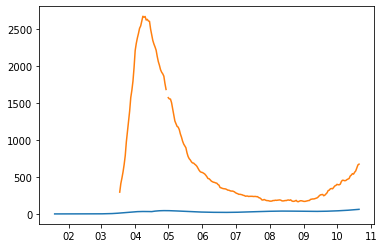

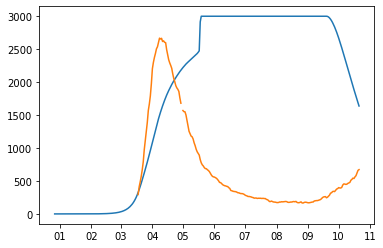

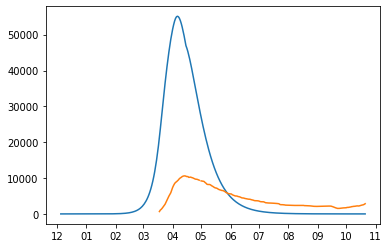

Deaths
best_error: 117.06455685728615


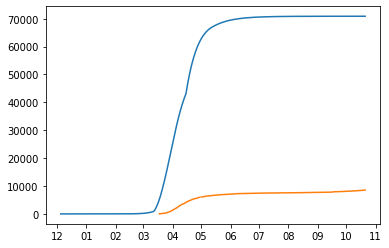

vector: [117.06455685728615]
ICUs
mean_deaths 69.10088450522707
[1.08849092e+02 1.34296990e+00 1.26474070e+00 7.72118636e-01
 4.50159181e-01 8.45410776e-02 2.65896602e-01 3.26967639e-02
 8.77756578e-01 1.55853798e+00 7.22299137e-01 1.67767072e+00
 1.72504045e+00 1.32702779e+01]
Beds
best_error: 80.04301139326616
vector: [80.04301139326616]
mean_deaths 48.724404560701615
[1.05334549e+02 1.32449075e+00 6.99140874e-01 1.40253829e-01
 5.17147299e-01 9.79480888e-02 1.81684126e-01 1.60542196e-01
 9.63858770e-01 1.11119212e+00 1.41534238e+00 1.23531921e+00
 6.69702611e-01 1.16023407e+01]
Beds


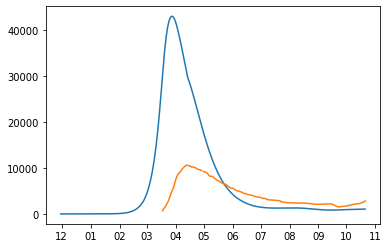

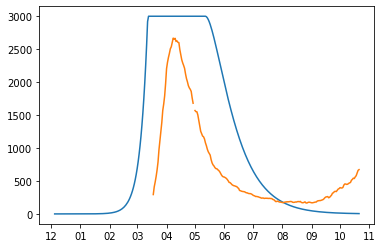

Deaths


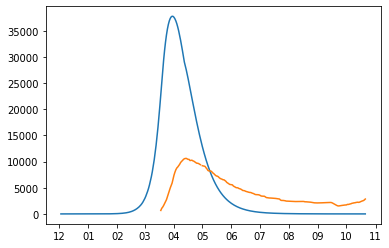

Deaths


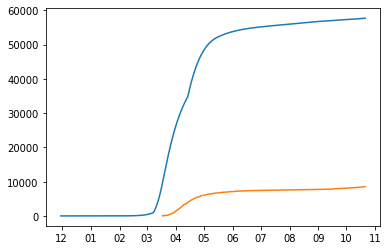

ICUs


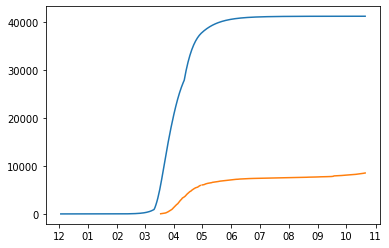

ICUs


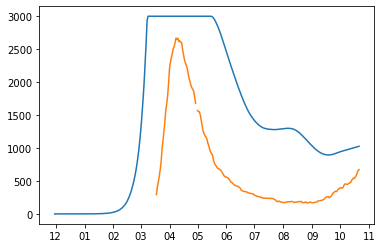

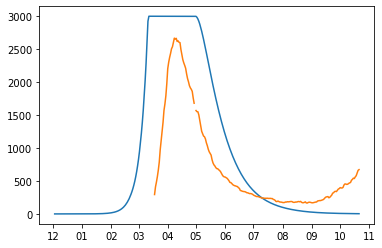

best_error: 26.24077846154505
vector: [26.24077846154505]
mean_deaths 3.6716901474601817
[5.06896405e+01 1.50568033e-01 5.16267272e-01 5.06340809e-01
 4.05953238e-01 2.64752147e-02 5.94536298e-01 1.73898491e-02
 8.20365986e-01 1.04948110e+00 9.05121251e-01 1.66066713e+00
 1.55199961e+00 2.62199777e+01]
Beds
best_error: 40.87605356695689
vector: [40.87605356695689]
mean_deaths 15.329124423963963
[1.01360669e+02 1.77990303e+00 8.61890562e-01 9.21756081e-01
 1.56964632e-02 5.69372159e-02 1.37409690e-01 1.25858894e-01
 8.99085551e-01 1.43168011e+00 1.40917266e+00 1.66761878e+00
 1.24124971e+00 9.41989242e+00]
Beds


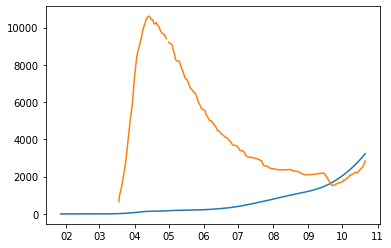

Deaths


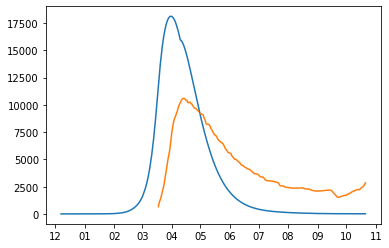

Deaths


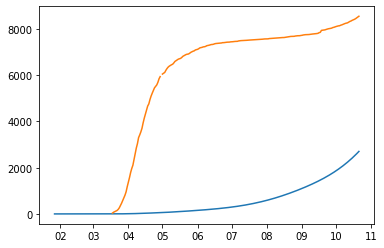

ICUs


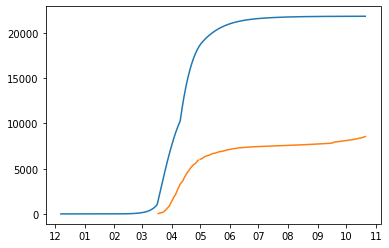

ICUs


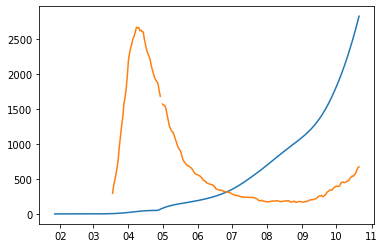

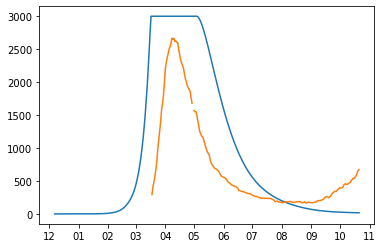

best_error: 17.86328085263735
vector: [17.86328085263735]
mean_deaths 3.911223988477604
[6.24380077e+01 1.82609031e+00 7.56497019e-01 8.98205468e-01
 9.47534270e-01 4.73038585e-02 1.61033605e-01 1.02083817e-01
 9.92504920e-01 1.70742000e+00 1.50189648e+00 6.53104518e-01
 5.63975511e-01 1.99165746e+01]
Beds


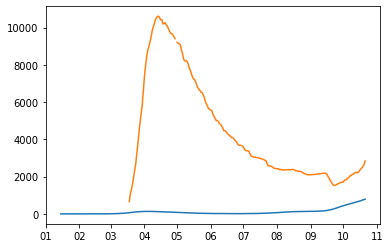

Deaths


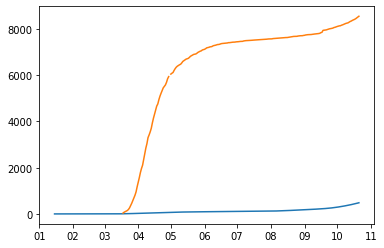

ICUs


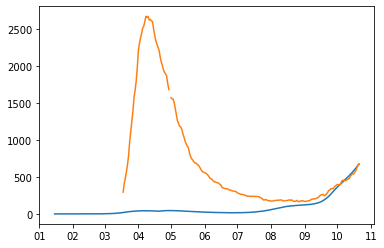

best_error: 19.553940700489964
vector: [19.553940700489964]
mean_deaths 4.027161687389372
[9.57493282e+01 1.98809580e+00 7.04517921e-01 6.86234083e-02
 8.55995090e-01 2.79523756e-02 4.49378536e-01 3.46674668e-02
 9.04777555e-01 1.64142755e+00 1.99254059e+00 5.30385119e-01
 9.17261602e-01 3.09454918e+01]
Beds


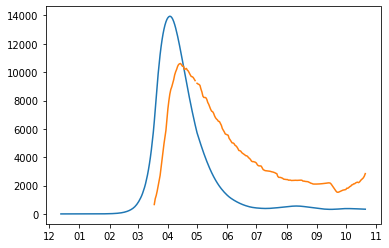

Deaths
best_error: 14.575123622898516
vector: [14.575123622898516]
mean_deaths 2.6885538369169035
[8.68042726e+01 1.30907748e+00 6.42343584e-01 5.03856944e-02
 6.71583487e-02 2.86500515e-02 5.23943276e-01 7.11587054e-03
 9.01791348e-01 1.56801864e+00 1.71333686e+00 1.00580132e+00
 7.02183538e-01 2.50520154e+01]
Beds


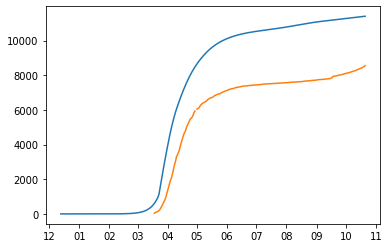

ICUs


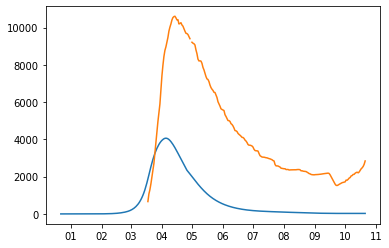

Deaths


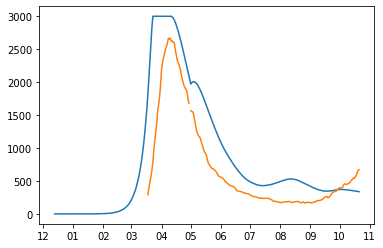

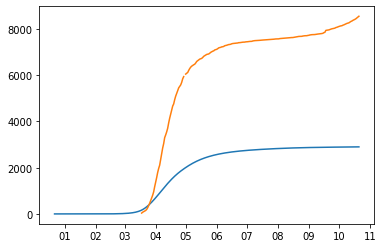

ICUs
best_error: 20.022099944220095
vector: [20.022099944220095]
mean_deaths 3.964559807656409
[5.53445995e+01 1.76245723e+00 8.37564421e-01 5.83335454e-01
 6.12009754e-01 5.12365724e-02 3.16205654e-01 1.12024487e-01
 5.04907966e-01 8.96847022e-01 6.24353763e-01 7.00743514e-01
 8.90153055e-01 6.55402735e+00]
Beds
best_error: 16.45557291929487
vector: [16.45557291929487]
mean_deaths 2.7854579837810043
[8.31964694e+01 1.63525809e+00 7.93255649e-01 5.47937564e-02
 3.58574917e-01 9.39689044e-02 1.29874468e-01 9.96675408e-03
 6.47581671e-01 5.07359203e-01 1.49980081e+00 8.79961247e-01
 1.26830233e+00 2.13639079e+01]
Beds


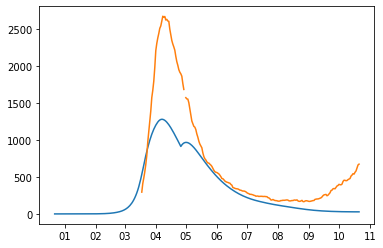

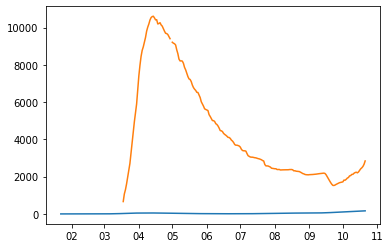

Deaths


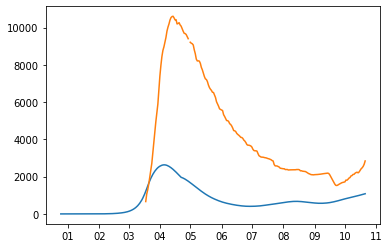

Deaths


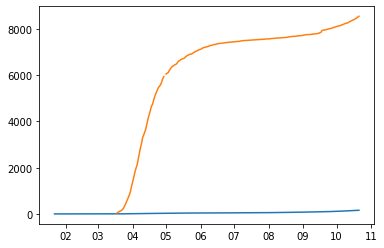

ICUs


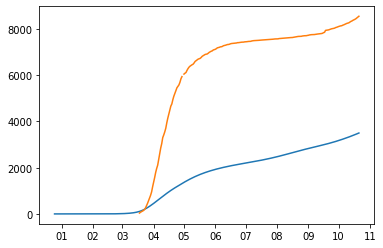

ICUs


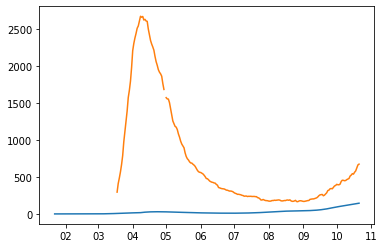

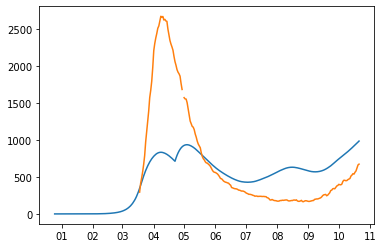

best_error: 20.921014362695924
vector: [20.921014362695924]
mean_deaths 3.9822543238465493
[53.16287196  1.66079643  0.63688731  0.54566026  0.37797413  0.08437362
  0.60679915  0.10140069  0.97328852  1.90362994  0.80297197  0.61283223
  0.93455578  4.38017631]
Beds
best_error: 31.521676556163698
vector: [31.521676556163698]
mean_deaths 3.7445170712520106
[5.36952135e+01 8.94317927e-01 8.11667083e-01 3.33208510e-01
 3.02309985e-01 7.76294631e-02 8.09878715e-01 1.64595867e-02
 9.20566766e-01 1.73104567e+00 8.42184557e-01 1.98219683e+00
 1.03998515e+00 5.78887820e+00]
Beds
best_error: 18.420452815575803
best_error: 16.913647013018462
vector: [16.913647013018462]
vector: [18.420452815575803]
mean_deaths 3.30602416538739
mean_deaths 3.3542494011231767
[8.13799910e+01 1.73120621e+00 7.00311330e-01 3.59638226e-01
 4.77079602e-01 8.12806172e-02 7.33816942e-01 3.42308911e-02
 7.87280579e-01 1.43747328e+00 1.49472519e+00 1.70459226e+00
 1.49698052e+00 3.69520379e+01][8.10549042e+01 1.55591189e

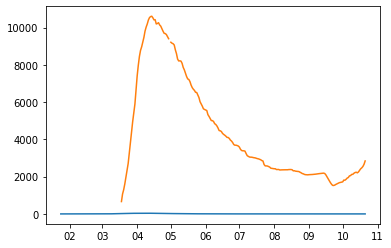

Deaths


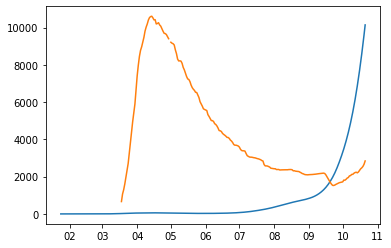

Deaths


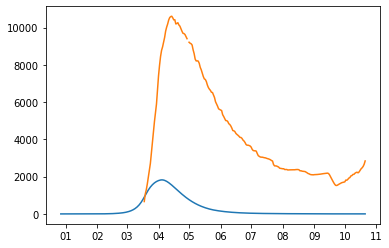

Deaths


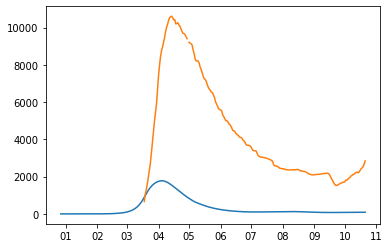

Deaths


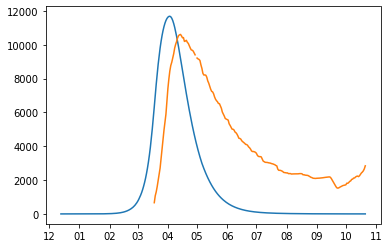

Deaths


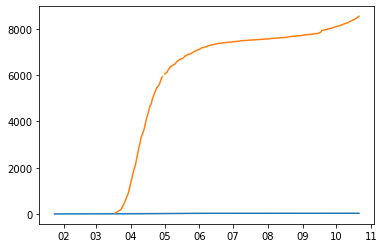

ICUs


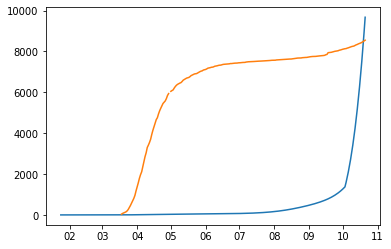

ICUs


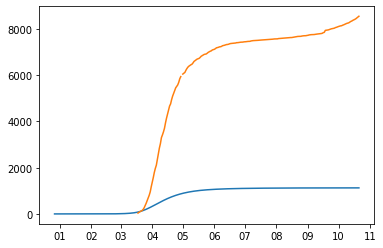

ICUs


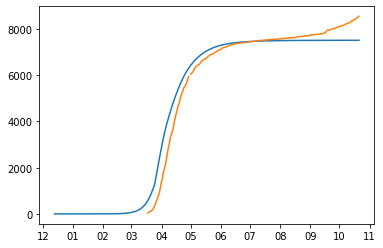

ICUs


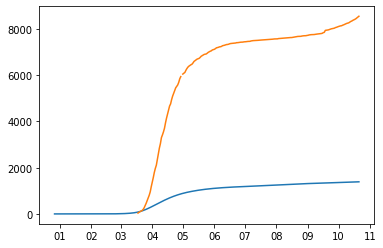

ICUs


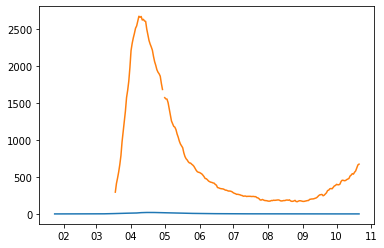

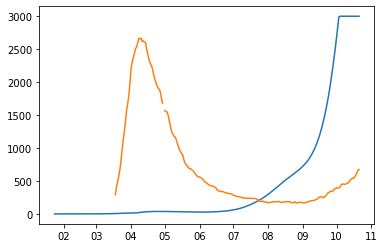

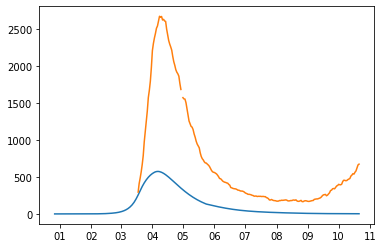

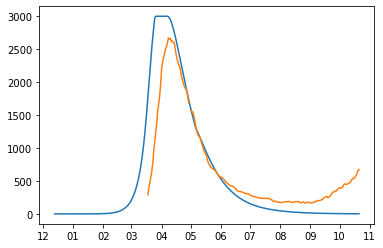

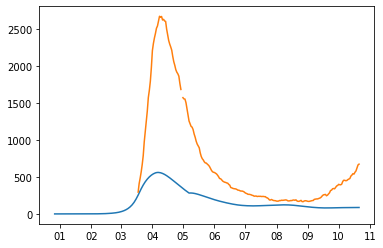

best_error: 20.377499896851052
vector: [20.377499896851052]
mean_deaths 3.977772909709924
[5.25819777e+01 1.78229597e+00 8.29982428e-01 2.72434501e-01
 3.26890085e-01 7.27621700e-02 8.51032034e-01 4.04687485e-02
 7.79098868e-01 1.93202816e+00 1.70612132e+00 1.87876465e+00
 1.25895519e+00 4.89077872e+01]
Beds


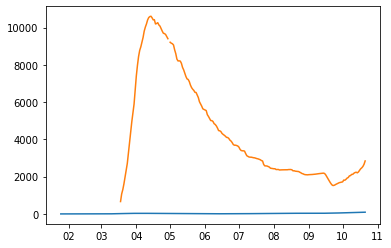

Deaths


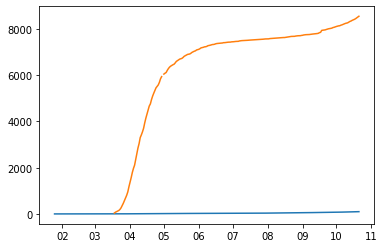

ICUs


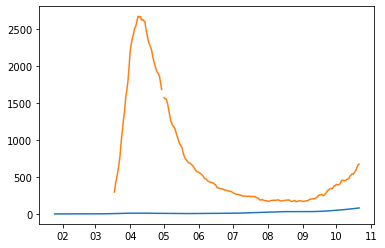

best_error: 14.202368898176628
vector: [14.202368898176628]
mean_deaths 2.0509328479988644
[8.92687928e+01 8.87545769e-01 6.98276579e-01 6.30220608e-01
 2.43487742e-01 8.41802371e-02 4.87797668e-01 9.92129740e-02
 6.33903762e-01 1.65195606e+00 1.01070843e+00 8.44663428e-01
 5.44802378e-01 4.36942774e+01]
Beds


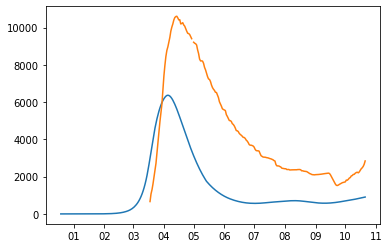

Deaths


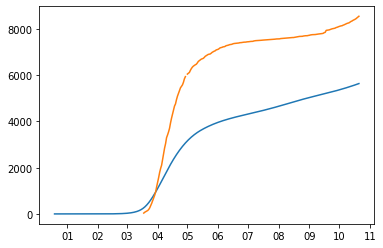

ICUs


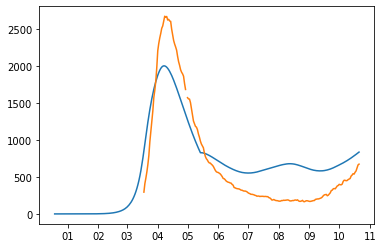

best_error: 18.79714835069435
vector: [18.79714835069435]
mean_deaths 1.76255537288007
[8.73424669e+01 5.72078803e-01 6.46149836e-01 6.78940670e-01
 3.04900402e-02 8.21103389e-02 2.58577568e-01 5.09741468e-02
 8.44312911e-01 1.75615014e+00 1.04991375e+00 1.22173050e+00
 8.70580289e-01 4.58785014e+01]
Beds
best_error: 81.85132970746054
vector: [81.85132970746054]
mean_deaths 4.778274058589887
[6.96540760e+01 1.26156413e+00 9.05643847e-01 6.42087290e-01
 3.62730681e-01 7.27584358e-02 8.68144016e-01 1.58204622e-02
 8.91370707e-01 1.22376303e+00 1.62862623e+00 7.17838308e-01
 1.19561093e+00 2.78230936e+01]
Beds


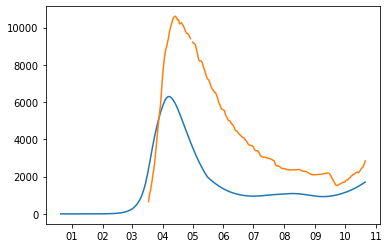

Deaths


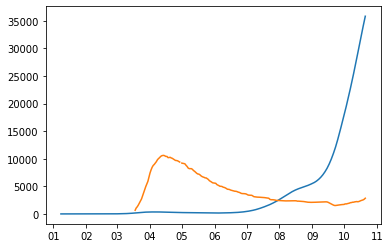

Deaths


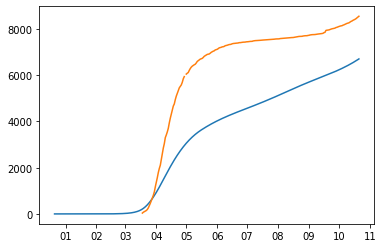

ICUs


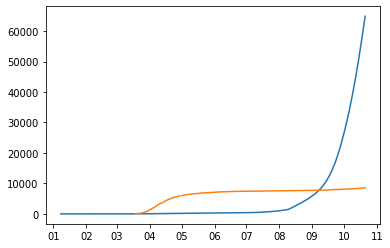

ICUs


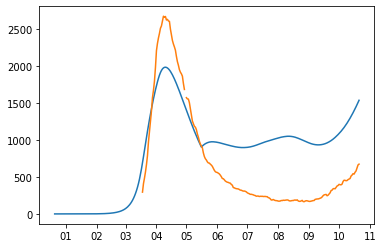

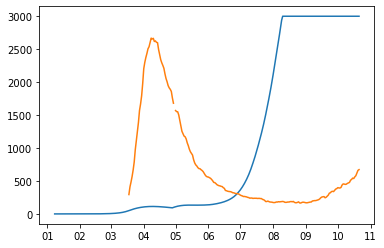

best_error: 18.079373247090672
vector: [18.079373247090672]
mean_deaths 3.280675074070619
[8.27729898e+01 1.64759910e+00 5.81022902e-01 3.54557595e-01
 5.55613266e-01 7.10581395e-02 2.37328711e-01 4.67325867e-02
 8.97601394e-01 6.67522220e-01 5.81116094e-01 1.26991298e+00
 9.54992646e-01 5.38835677e+01]
Beds


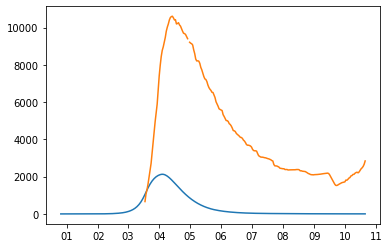

Deaths


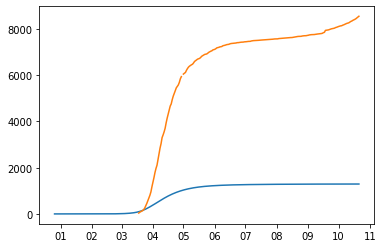

ICUs
best_error: 60.20805502806338
vector: [60.20805502806338]
mean_deaths 3.730833898282244
[6.42922714e+01 4.97006643e-01 7.07070493e-01 6.96726398e-01
 3.93208671e-02 7.79160244e-02 6.11241644e-01 1.74979714e-01
 9.98189113e-01 1.63643178e+00 1.83022997e+00 1.78538533e+00
 6.35693188e-01 2.72193035e+01]
Beds


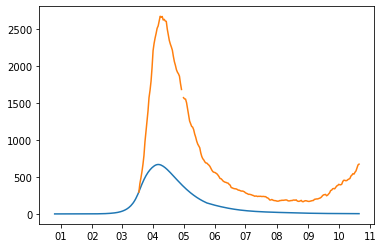

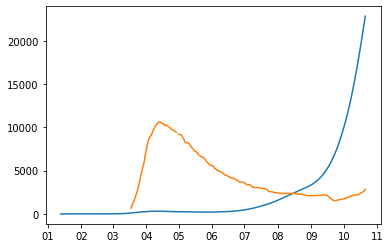

Deaths


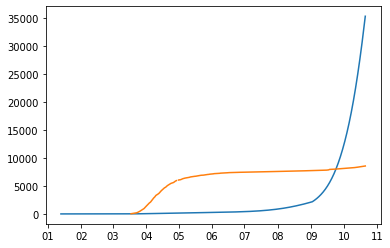

ICUs


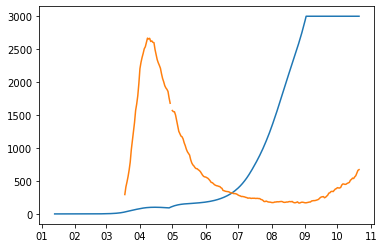

best_error: 18.533911746597465
vector: [18.533911746597465]
mean_deaths 3.4340144752546884
[7.99376421e+01 1.68325055e+00 5.90602428e-01 6.01266309e-01
 3.28253539e-01 7.33897956e-02 8.45490030e-01 1.10058869e-01
 6.99592834e-01 1.32957062e+00 6.29062699e-01 1.33584929e+00
 1.42723137e+00 1.35675878e+00]
Beds
best_error: 20.50027553346964
vector: [20.50027553346964]
mean_deaths 3.9363887472675785
[6.24380077e+01 1.25114795e+00 7.56497019e-01 8.98205468e-01
 7.88754079e-02 9.08876732e-02 5.71285520e-01 2.04527274e-02
 9.92504920e-01 1.70742000e+00 5.78161592e-01 6.53104518e-01
 1.57581533e+00 2.45903837e+01]
Beds


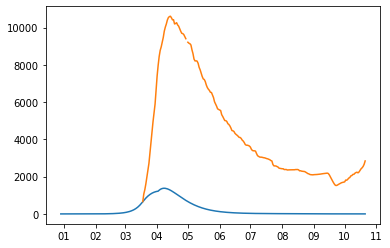

Deaths


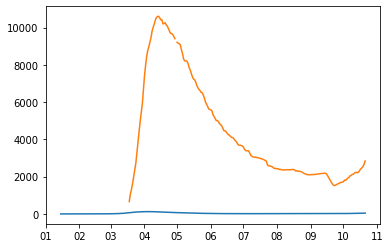

Deaths


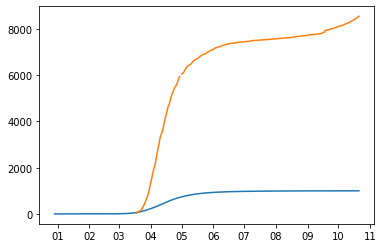

ICUs


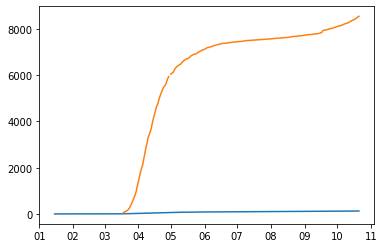

ICUs


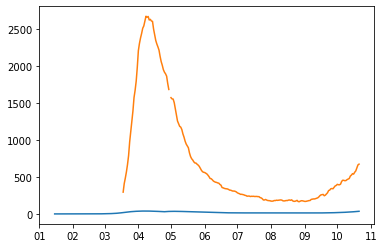

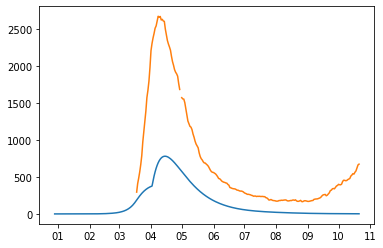

best_error: 17.57957353539382
vector: [17.57957353539382]
mean_deaths 3.741592249365395
[7.23616908e+01 1.85424766e+00 8.16957459e-01 6.74010663e-01
 3.73848607e-01 6.33658480e-02 8.16334701e-01 4.31844804e-02
 9.41903709e-01 5.07359203e-01 1.06162956e+00 1.58356291e+00
 1.43992575e+00 2.13639079e+01]
Beds
best_error: 18.103789608611272
vector: [18.103789608611272]
mean_deaths 3.5941910598553197
[7.77193437e+01 1.85112963e+00 7.61331528e-01 8.72232778e-01
 4.83518189e-01 8.60309853e-02 7.50862302e-01 3.34257029e-02
 9.09771578e-01 1.20595179e+00 8.44281740e-01 1.85568528e+00
 8.49229381e-01 4.10620394e+01]
Beds


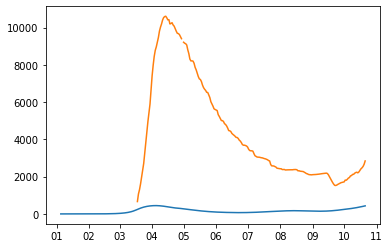

Deaths


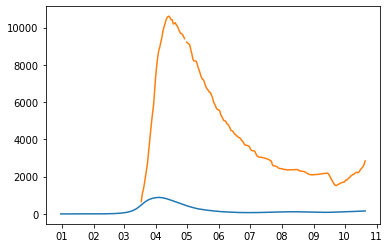

Deaths


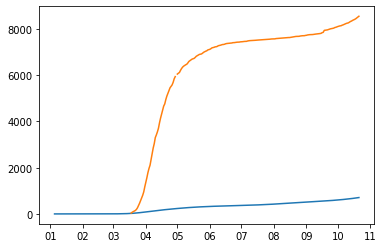

ICUs


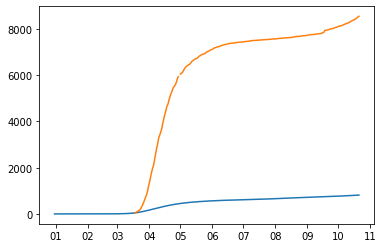

ICUs


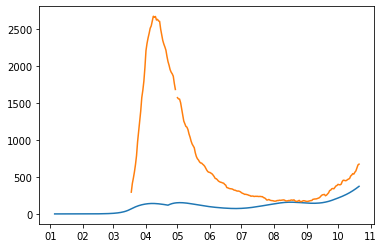

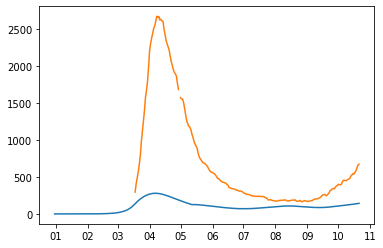

best_error: 15.404729742144042
vector: [15.404729742144042]
mean_deaths 2.946282359074162
[8.56112498e+01 1.58687481e+00 7.49107208e-01 7.86446343e-01
 3.22713259e-01 7.65205994e-02 9.56569152e-01 7.78108919e-02
 9.44893123e-01 1.63153864e+00 9.52597575e-01 1.72452939e+00
 1.34541089e+00 3.57287388e+01]
Beds


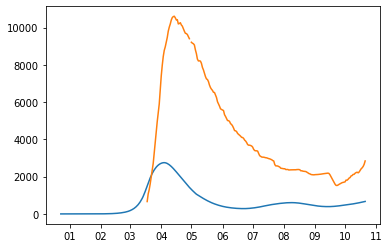

Deaths


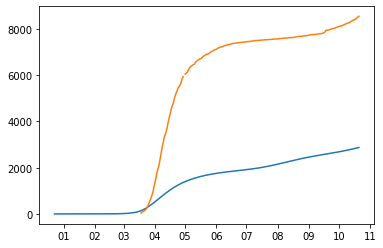

ICUs


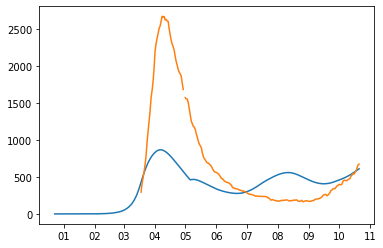

best_error: 14.194487397575884
vector: [14.194487397575884]
mean_deaths 2.691603104740615
[8.87150235e+01 1.70577588e+00 7.70758217e-01 8.89140480e-01
 6.19862994e-02 9.68109391e-02 7.65652926e-01 1.01255040e-01
 6.16227713e-01 1.71891816e+00 1.61603867e+00 1.09286038e+00
 6.65007715e-01 1.33662419e+01]
Beds
best_error: 17.674191479723895
vector: [17.674191479723895]
mean_deaths 3.4013727384558345
[79.77545892  1.51701586  0.636003    0.13448945  0.4096588   0.09904802
  0.8695816   0.18488727  0.7045093   0.62128691  0.89347823  1.54397112
  0.91889791 37.0421087 ]
Beds
best_error: 18.723744810277058
vector: [18.723744810277058]
mean_deaths 3.46310522712907
[9.69850873e+01 1.46674438e+00 7.83996688e-01 2.90915914e-01
 1.60965449e-01 6.11919419e-02 5.63703733e-01 2.64528858e-02
 7.10100112e-01 5.03761316e-01 1.69430533e+00 1.85487935e+00
 1.26417007e+00 3.60284893e+01]
Beds


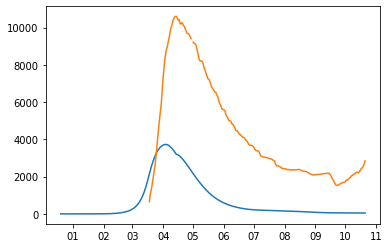

Deaths


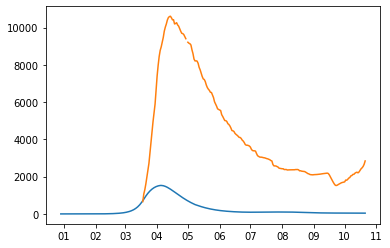

Deaths


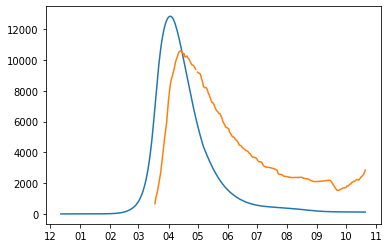

Deaths


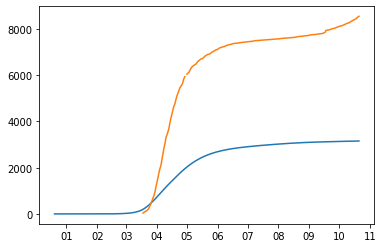

ICUs


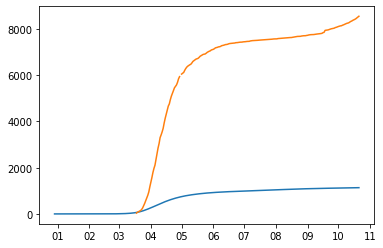

ICUs


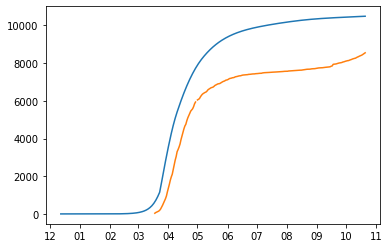

ICUs


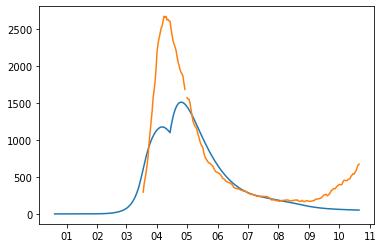

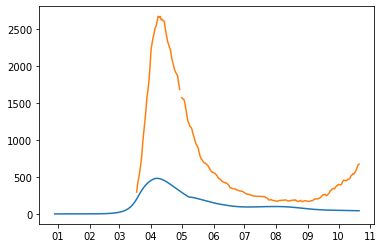

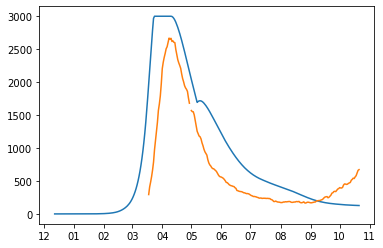

best_error: 11.710962753447562
vector: [11.710962753447562]
mean_deaths 2.0252620602110962
[9.08553854e+01 1.07660542e+00 5.63965186e-01 2.69765970e-01
 8.88375544e-01 4.37659524e-03 3.50023137e-01 8.44335917e-02
 9.16581405e-01 1.21039440e+00 6.84424153e-01 1.34423252e+00
 7.73956347e-01 3.82584054e+01]
Beds
best_error: 17.861890039180995
vector: [17.861890039180995]
mean_deaths 2.408331536652633
[8.76741104e+01 1.73910970e+00 7.26907930e-01 2.11582930e-01
 8.17417063e-01 8.37163664e-02 2.89839255e-01 1.21942938e-02
 7.96488034e-01 1.75069414e+00 6.50042420e-01 1.13767653e+00
 1.82936877e+00 5.22941614e+01]
Beds


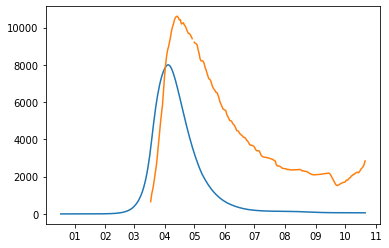

Deaths


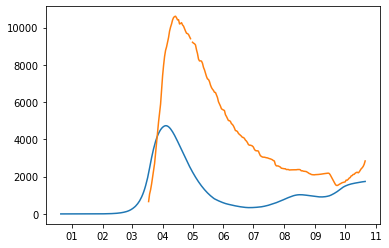

Deaths


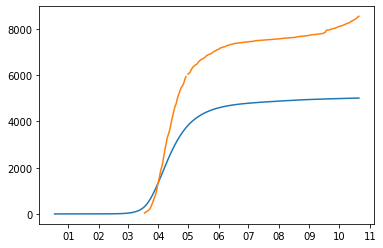

ICUs


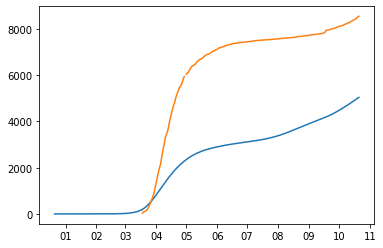

ICUs


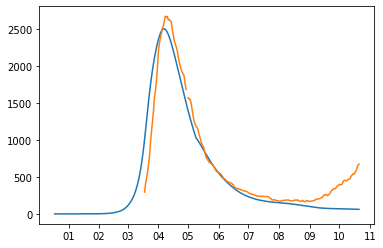

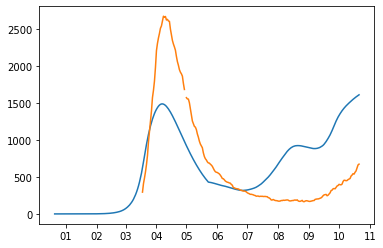

best_error: 14.463085991318739
vector: [14.463085991318739]
mean_deaths 2.7390453917673567
[8.80635496e+01 1.82098051e+00 6.83318112e-01 3.45475403e-01
 3.10837233e-01 1.08695863e-02 8.85938755e-01 1.40430118e-01
 7.27297547e-01 1.92516418e+00 9.97973846e-01 1.80009180e+00
 1.16818747e+00 4.52771326e+01]
Beds


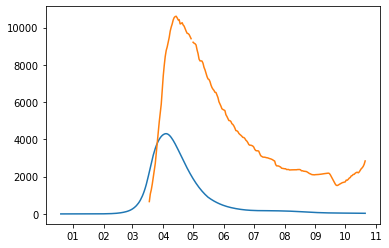

Deaths


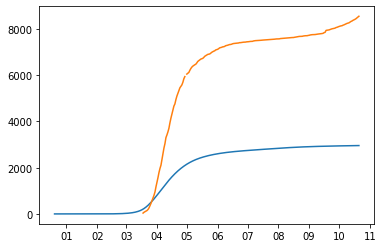

ICUs


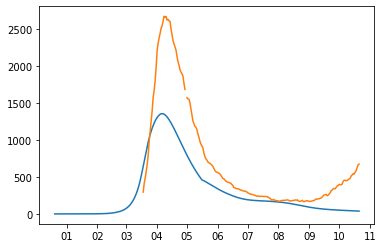

best_error: 17.58141806636583
vector: [17.58141806636583]
mean_deaths 3.3346117940729076
[8.16823361e+01 1.77619951e+00 6.56479995e-01 9.64902671e-01
 7.89570683e-01 6.48261369e-02 4.96872721e-01 1.46873145e-01
 5.17719942e-01 1.64137001e+00 1.09782890e+00 9.08607020e-01
 1.11844297e+00 1.93833778e+01]
Beds


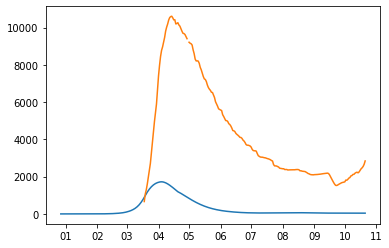

Deaths


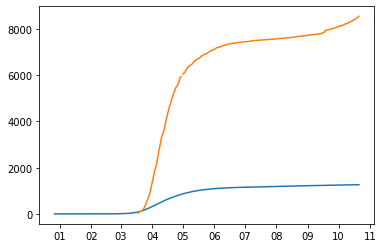

ICUs
best_error: 16.647057892384105
vector: [16.647057892384105]
mean_deaths 3.1244997957813783
[8.32262021e+01 1.05519777e+00 6.16700738e-01 8.70078138e-01
 4.91434873e-01 9.25616440e-02 3.59118498e-01 7.66783279e-02
 8.16034052e-01 1.66380873e+00 7.83813276e-01 1.93299200e+00
 1.41719499e+00 3.40260642e+01]
Beds


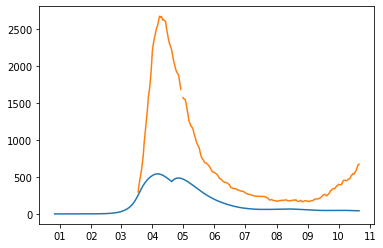

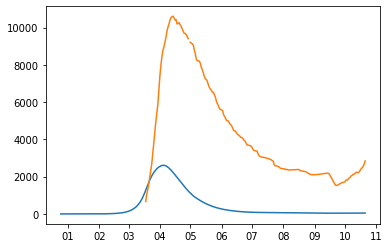

Deaths


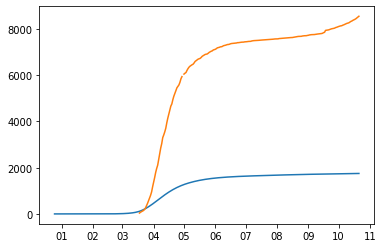

ICUs


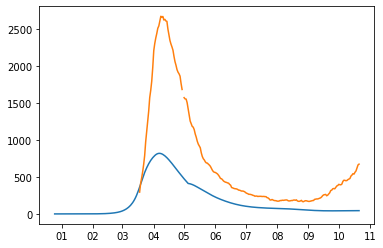

best_error: 16.23236762601292
vector: [16.23236762601292]
mean_deaths 3.4518430785046466
[7.86893705e+01 1.63105366e+00 8.00620091e-01 7.02059645e-01
 4.72290505e-01 2.03280472e-02 6.65035143e-01 5.02854663e-02
 6.58537360e-01 1.48640025e+00 5.97991541e-01 1.61256576e+00
 1.40604088e+00 4.12047297e+01]
Beds


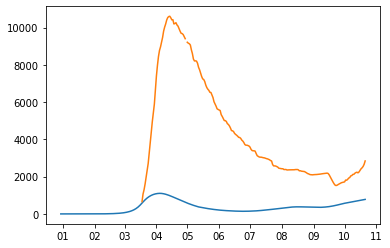

Deaths


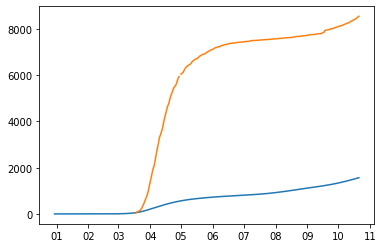

ICUs
best_error: 15.619197511305856
vector: [15.619197511305856]
mean_deaths 3.2892557384067302
[79.28227574  0.84590774  0.65619469  0.8555865   0.18052689  0.08406089
  0.75479141  0.11005887  0.69959283  1.41766963  0.87807586  1.8004431
  0.72976136 23.24207203]
Beds


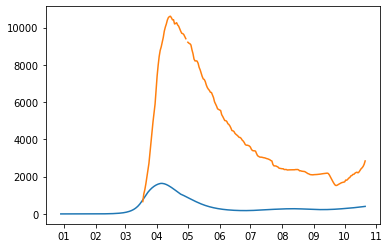

Deaths


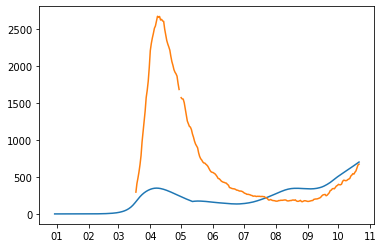

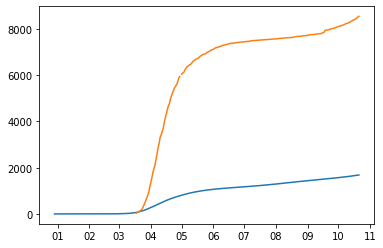

ICUs


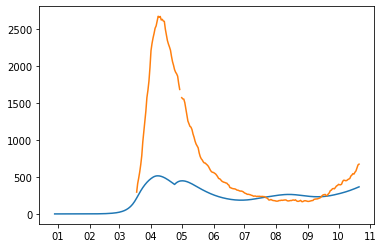

best_error: 16.324316569418013
vector: [16.324316569418013]
mean_deaths 1.862277185282267
[9.24533712e+01 1.52525215e+00 7.66526935e-01 6.84425098e-01
 7.72044731e-01 2.72346377e-02 1.32070948e-01 7.75629149e-02
 7.47349328e-01 1.98084942e+00 5.74866531e-01 1.64769774e+00
 7.00322156e-01 5.97584766e+01]
Beds


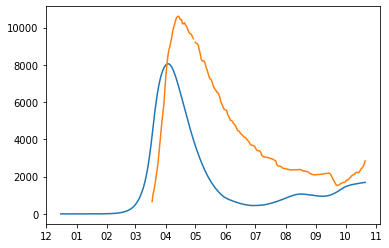

Deaths


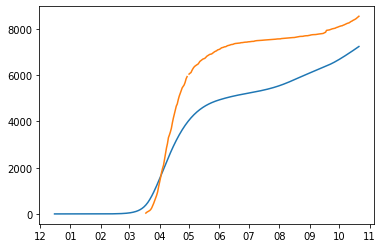

ICUs


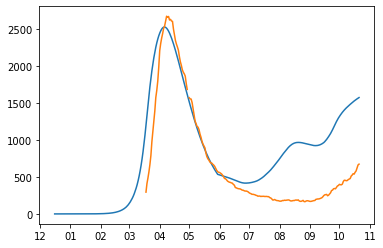

best_error: 12.835371881264882
vector: [12.835371881264882]
mean_deaths 1.7451930912031257
[9.31961334e+01 1.45496688e+00 7.96737238e-01 5.40683796e-01
 1.68211150e-01 4.58774153e-02 5.32824389e-02 4.16165718e-02
 7.72414709e-01 8.10562628e-01 8.97840513e-01 1.22194388e+00
 1.48684263e+00 2.26814233e+01]
Beds


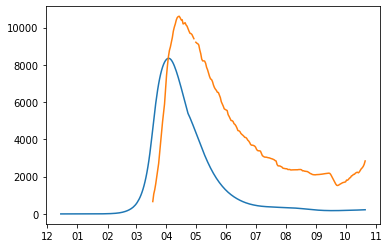

Deaths


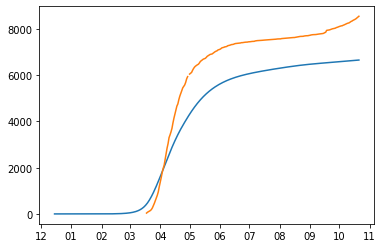

ICUs


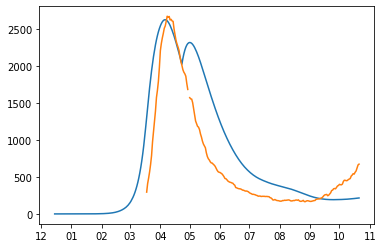

best_error: 14.968297800363246
vector: [14.968297800363246]
mean_deaths 2.8201207257294696
[8.10549042e+01 7.05228596e-01 5.94232265e-01 2.76255659e-01
 6.40393874e-01 2.48990303e-02 3.90323416e-01 1.00950496e-01
 9.14451880e-01 1.06331811e+00 9.57863198e-01 1.35257659e+00
 6.79102915e-01 2.53530862e+01]
Beds


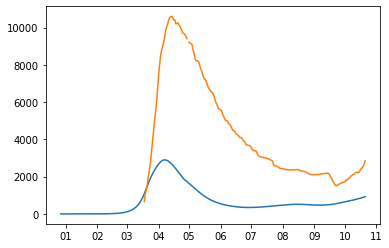

Deaths


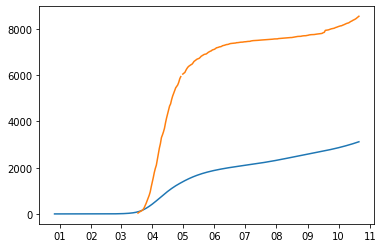

ICUs


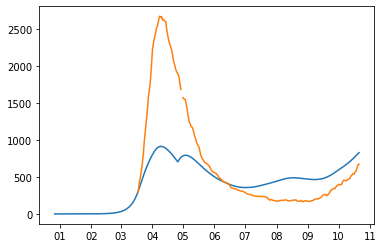

best_error: 19.33276320336671
vector: [19.33276320336671]
best_error: 14.188507603047027
mean_deaths 3.7822653014832754
vector: [14.188507603047027]
[7.02682358e+01 1.05359002e+00 6.07953677e-01 6.19855754e-01
 9.08938215e-01 3.97049770e-02 5.67665911e-01 1.05108005e-01
 7.16612773e-01 1.64471766e+00 1.46036480e+00 1.26504969e+00
 6.57686959e-01 5.09598935e+01]mean_deaths 2.666287652016887

[8.63146584e+01 1.53003060e+00 6.02730001e-01 1.56956554e-02
 7.26797214e-01 9.96446001e-02 6.58898050e-01 6.33167571e-02
 5.79702524e-01 1.40232255e+00 1.57871954e+00 1.69201278e+00
 7.31185631e-01 4.89743305e+01]Beds

Beds


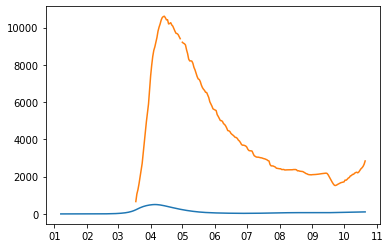

Deaths


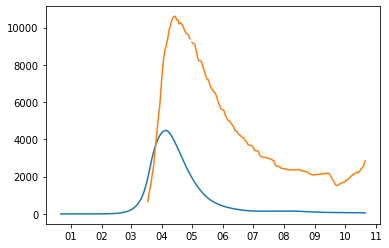

Deaths


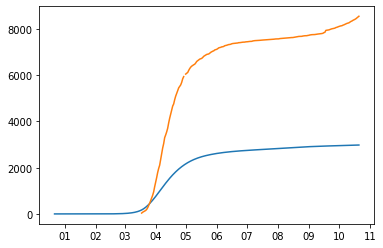

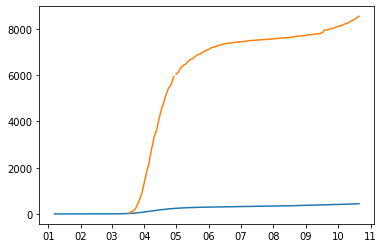

ICUs
ICUs


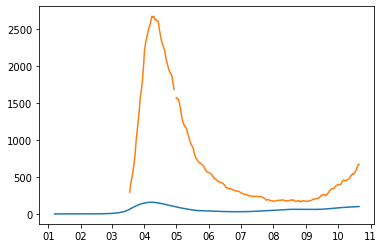

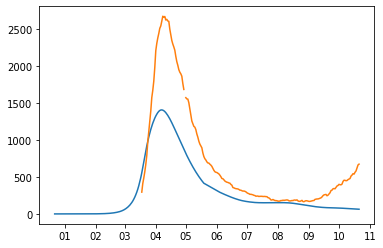

Process ForkPoolWorker-10:
Process ForkPoolWorker-14:
Process ForkPoolWorker-9:
Process ForkPoolWorker-13:
Process ForkPoolWorker-4:
Process ForkPoolWorker-7:
Process ForkPoolWorker-16:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-12:
Process ForkPoolWorker-5:
Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-1:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/sergioacamel

  File "/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/sergioacamelogomez/opt/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/sergioacamelogomez/opt/anaconda3/

  File "/Users/sergioacamelogomez/Dropbox/covid-optimization/fast_gradient/fast_group.py", line 141, in take_time_step
    self.update_contact_matrix(season)
  File "/Users/sergioacamelogomez/Dropbox/covid-optimization/fast_gradient/fast_group.py", line 141, in take_time_step
    self.update_contact_matrix(season)
  File "/Users/sergioacamelogomez/Dropbox/covid-optimization/fast_gradient/fast_group.py", line 141, in take_time_step
    self.update_contact_matrix(season)
  File "/Users/sergioacamelogomez/Dropbox/covid-optimization/fast_gradient/fast_group.py", line 215, in take_time_step
    self.update_ICU()
  File "/Users/sergioacamelogomez/Dropbox/covid-optimization/fast_gradient/fast_group.py", line 141, in take_time_step
    self.update_contact_matrix(season)
  File "/Users/sergioacamelogomez/Dropbox/covid-optimization/fast_gradient/fast_group.py", line 255, in update_contact_matrix
    self.contact_matrix[g1,g2] += self.M_new[g1,g2,act]*(self.alphas[g1,act]**self.mixing_method['par

KeyboardInterrupt: 

In [35]:
from scipy.optimize import minimize, Bounds, shgo, differential_evolution, dual_annealing
epsilon = 0.1
result = differential_evolution(error, [(50,140)]+[windows['alpha_mixing']]*1+[windows['transmission']]+[[0,1]]*2+[windows['school_l'],[0,1],[0,0.2],[0.5,1]]+[[0.50,2.0]]+[[0.50,2.0]]*3+[[0,60]],workers = -1)

#windows["mu"],windows["sigma"],windows["p_ICU"],windows["p_H"],windows["lambda_H_R"],windows["lambda_H_D"],windows["lambda_ICU_R"],windows["lambda_ICU_D"]


In [ ]:
error([7.83199596e+01, 1.50524287e+00, 8.40278623e-01, 3.27606257e-01,
 1.69649676e-02, 6.93157632e-02, 2.25414737e-01, 6.74164208e-02,
 9.92296980e-01])


In [31]:
import copy
import math
import matplotlib.dates as mdates
best_v = 0
best_error = float('inf')
validation_date = datetime.strptime("2020-10-21", '%Y-%m-%d')
days_ahead_opt = 7.83199596e+01
alpha_opt = 1.50524287e+00

def error_grad(v):
    
    vector_upper_model_data = []
    vector_errors = []
    
    for n_sample in range(n_samples):
        days_ahead = days_ahead_opt
        alpha_mixing_home = alpha_opt
        alpha_mixing_work = alpha_opt
        alpha_mixing_transport = alpha_opt
        alpha_mixing_school = alpha_opt
        alpha_mixing_other = alpha_opt
        alpha_mixing_leisure = alpha_opt
        
        mix_1 = v[1]
        mix_2 = v[2]
        
        alphas_d = {
            'work':alpha_mixing_work,
            'transport':alpha_mixing_transport,
            'school':alpha_mixing_school,
            'other':alpha_mixing_other,
            'leisure':alpha_mixing_leisure,
            'home':alpha_mixing_home,
        }

        gamma_mixing_before = 1.0
        gamma_mixing_after = 1.0


        upper_bound_home = 1.0
        upper_bound_leisure = 1.0
        upper_bound_other = 1.0
        upper_bound_school = 1.0
        upper_bound_work = 1.0
        upper_bound_transport = 1.0

        school_lockdown = v[3]
        school_may = v[4]
        school_jun_jul_aug = v[5]
        school_sep_oct = v[6]

        beta_normal = original_beta
        beta_vacation = beta_normal*v[0]

        days_change_model = 0


        google['other'] = mix_1*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100+(1-mix_1)*(google["grocery_and_pharmacy_percent_change_from_baseline"]+100)/100
        google['leisure'] = mix_2*(google["parks_percent_change_from_baseline"]+100)/100+(1-mix_2)*(google["retail_and_recreation_percent_change_from_baseline"]+100)/100


        # Number of days
        days_before_date_1 = int(days_ahead)
        days_between_dates_1_2 = (date_2-date_1).days
        days_between_dates_2_3 = (date_3-date_2).days
        days_between_dates_3_4 = (date_4-date_3).days
        days_between_dates_4_5 = (date_5-date_4).days
        days_after_date_5 = (final_date-date_5).days
        total_days = days_before_date_1 + days_between_dates_1_2 + days_between_dates_2_3 + days_between_dates_3_4 + days_between_dates_4_5+ days_after_date_5
        days_denom = days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4+days_between_dates_4_5


        # Some additional calculations
        validation_days = days_before_date_1 + (validation_date-date_1).days
        vacation_start_days = days_before_date_1 + (vacation_start-date_1).days
        vacation_end_days = days_before_date_1 + (vacation_end-date_1).days


        # Construct initialization
        initialization = copy.deepcopy(original_initialization)
        for i,group in enumerate(age_groups):
            if group == "age_group_40_49":
                initialization[group]["I"] = initialization[group]["I"] + 1
                initialization[group]["S"] = initialization[group]["S"] - 1
            initialization[group]["N"] = initialization[group]["S"] + initialization[group]["E"] + initialization[group]["I"] + initialization[group]["R"]


        # Alphas
        a_before_google = {
            'home':upper_bound_home,
            'leisure':upper_bound_leisure,
            'other':upper_bound_other,
            'school':upper_bound_school,
            'transport':upper_bound_transport,
            'work':upper_bound_work
        }



        # Determine mixing method
        #     mixing_method_before = {
        #         "name":"mult",
        #         "param_alpha":alpha_mixing_before,
        #         "param_beta":alpha_mixing_before,
        #     }

        #     # Determine mixing method
        #     mixing_method_after = {
        #         "name":"mult",
        #         "param_alpha":alpha_mixing_after,
        #         "param_beta":alpha_mixing_after,
        #     }
        #dynModel.mixing_method = mixing_method_after




        # Calculate alphas
        alphas_vec = []
        for t in range(days_before_date_1-days_between_google):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = a_before_google
            alphas_vec.append(alphas)

        counter = 0
        for t in range(days_between_google):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':1.0,
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_1_2):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_lockdown*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_2_3):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_may*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_3_4):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_may*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_between_dates_4_5):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_jun_jul_aug*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)   
            counter += 1
        for t in range(days_after_date_5):
            alphas = {}
            for age_group in age_groups:
                alphas[age_group] = {
                    'home':1.0,
                    'leisure':google['leisure'][counter]*samples[n_sample,counter,0],
                    'other':google['other'][counter]*samples[n_sample,counter,1],
                    'school':school_sep_oct*samples[n_sample,counter,2],
                    'transport':google['transport'][counter]*samples[n_sample,counter,3],
                    'work':google['work'][counter]*samples[n_sample,counter,4],
                }
            alphas_vec.append(alphas)
            counter += 1




        #     mixing_vec = []
        #     for t in range(int(vacation_start_days+days_change_model)):
        #         mixing_vec.append(mixing_method_before)
        #     for t in range(int(vacation_start_days+days_change_model),total_days):
        #         mixing_vec.append(mixing_method_after)




        # Calculate tests
        tests = np.zeros(len(age_groups))


        # Run model
        model_data_beds = {ag:[] for ag in age_groups+["total"]}
        model_data_icus = {ag:[] for ag in age_groups+["total"]}
        model_data_deaths = {ag:[] for ag in age_groups+["total"]}

        state = state_to_matrix(initialization)
        t_beds = 0
        t_icus = 0
        t_deaths = 0
        for i,ag in enumerate(age_groups):
            state_H = state[i,cont.index("H")]
            state_ICU = state[i,cont.index("ICU")]
            state_D = state[i,cont.index("D")]
            model_data_beds[ag].append(state_H)
            model_data_icus[ag].append(state_ICU)
            model_data_deaths[ag].append(state_D)
            t_beds+= state_H
            t_icus+= state_ICU
            t_deaths+= state_D
        model_data_beds["total"].append(t_beds)
        model_data_icus["total"].append(t_icus)
        model_data_deaths["total"].append(t_deaths)

        recalc_days = [0,
                     days_before_date_1,
                     days_before_date_1+days_between_dates_1_2,
                     days_before_date_1+days_between_dates_1_2+days_between_dates_2_3,
                     days_before_date_1+days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4,
                     days_before_date_1+days_between_dates_1_2+days_between_dates_2_3+days_between_dates_3_4+days_between_dates_4_5,
                    int(vacation_start_days)
                    ]

        dynModel.beta = np.zeros((len(age_groups),len(dynModel.groups[age_groups[0]].parameters["beta"])))
        for i in range(len(age_groups)):
            for j in range(len(dynModel.groups[age_groups[0]].parameters["beta"])):
                if j < int(vacation_start_days+days_change_model):
                    dynModel.beta[i,j] = beta_normal
                else:
                    dynModel.beta[i,j] = beta_vacation

        for t in range(total_days):
            current_date = date_1+timedelta(days=t-days_before_date_1)
            day_of_week = current_date.weekday()

            if t in recalc_days:
                update_contacts = True
            else:
                update_contacts = False

            if day_of_week <= 4:
                season = "new"
                dynModel.mixing_method = {
                    "name":"mult",
                    "param_alpha":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                    "param_beta":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                }
            else:
                season = "new"
                dynModel.mixing_method = {
                    "name":"mult",
                    "param_alpha":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                    "param_beta":{
                        'work':alpha_mixing_work,
                        'transport':alpha_mixing_transport,
                        'school':alpha_mixing_school,
                        'other':alpha_mixing_other,
                        'leisure':alpha_mixing_leisure,
                        'home':alpha_mixing_home,
                    },
                }

            #dynModel.mixing_method = mixing_vec[t]

            state,_ = dynModel.take_time_step(state, tests, tests, alphas_to_matrix(alphas_vec[t]), t, season, update_contacts=update_contacts)
            t_beds = 0
            t_icus = 0
            t_deaths = 0
            for i,ag in enumerate(age_groups):
                state_H = state[i,cont.index("H")]
                state_ICU = state[i,cont.index("ICU")]
                state_D = state[i,cont.index("D")]
                model_data_beds[ag].append(state_H)
                model_data_icus[ag].append(state_ICU)
                model_data_deaths[ag].append(state_D)
                t_beds+= state_H
                t_icus+= state_ICU
                t_deaths+= state_D
            #print(t_beds)
            model_data_beds["total"].append(t_beds)
            model_data_icus["total"].append(t_icus)
            model_data_deaths["total"].append(t_deaths)


        initial_date = date_1-timedelta(days=days_before_date_1)

        # Calculate the days of the model
        days_model = [initial_date+timedelta(days = t) for t in range(total_days + 1)]

        # Indices where to put the real data
        indices = [(datetime.strptime(d, '%Y-%m-%d') - initial_date).days for d in days]

        # Real data
        real_data_beds = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
        real_data_icus = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}
        real_data_deaths = {ag:[float('nan')]*len(days_model) for ag in age_groups+["total"]}

        for k,ind in enumerate(indices):
            for ag in age_groups+["total"]:
                real_data_beds[ag][ind] = beds_real[ag][k]
                real_data_icus[ag][ind] = icus_real[ag][k]
                real_data_deaths[ag][ind] = deaths_real[ag][k]


        error_constant = 1.0
        error_beds = 0
        error_icus = 0
        error_deaths = 0
        error_beds_total = 0
        for ag in old_age_groups:
            error_beds += np.nanmean((np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag]))/np.array(real_data_beds[ag]))[0:validation_days-1])
            #error_beds += error_constant*np.nanmean((np.abs(np.array(model_data_beds[ag])-np.array(real_data_beds[ag]))/np.array(real_data_beds[ag]))[validation_days-1:validation_days])
            #error_icus += np.nanmean(np.abs(np.array(model_data_icus[ag])-np.array(real_data_icus[ag])))
            #error_deaths += np.nanmean(np.abs(np.array(model_data_deaths[ag])-np.array(real_data_deaths[ag])))
        error_beds_total += np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[0:validation_days-1])
        error_beds_total += error_constant*np.nanmean((np.abs(np.array(model_data_beds["total"])-np.array(real_data_beds["total"]))/np.array(real_data_beds["total"]))[validation_days-1:validation_days])
        #error_icus_total = np.nanmean(np.abs(np.array(model_data_icus["total"])-np.array(real_data_icus["total"])))
        #error_deaths_total = np.nanmean(np.abs(np.array(model_data_deaths["total"])-np.array(real_data_deaths["total"])))




        #diff = np.array(model_data_beds["total"])-np.array(real_data_beds["total"])
        #error_beds_above = np.nanmean([max(d,0) for d in diff])
        #error_beds_below = -np.nanmean([min(d,0) for d in diff])

        #cumm_beds_model = [sum([model_data_beds["total"][k] for k in range(i+1) if not math.isnan(real_data_beds["total"][k])]) for i in range(len(model_data_beds["total"]))]
        #cumm_beds_real = [sum([real_data_beds["total"][k] for k in range(i+1) if not math.isnan(real_data_beds["total"][k])]) for i in range(len(real_data_beds["total"]))]
        #diff_cumm = np.array(cumm_beds_model)-np.array(cumm_beds_real)
        #error_cumm_above = np.nanmean([max(d,0) for d in diff_cumm])
        #error_cumm_below = -np.nanmean([min(d,0) for d in diff_cumm])



        #     error = error_beds_total
        #     error = mult_icus*error_icus_total
        #     error = mult_deaths*error_deaths_total
        upper_model_data = model_data_beds["total"]
        upper_days_model = days_model
        upper_real_data = real_data_beds["total"]
        error = error_beds+5*error_beds_total

        vector_errors.append(error)
        vector_upper_model_data.append(upper_model_data)
        

    error = np.mean(vector_errors)

    
    global best_error
    global best_v
    if error<best_error:
        best_error = error
        print("best_error:",best_error)
        print("vector:",vector_errors)
        best_v = v
        print(v)

        plt.figure(1)
        for n_sample in range(n_samples):
            plt.plot(upper_days_model, vector_upper_model_data[n_sample], label="Prediction")
        plt.plot(upper_days_model, upper_real_data, label="Real")
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m"))
        plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
        plt.show()
        

    return error



In [34]:
grad_0 = [0.5, 0.5, 0.5, 0.05, 0.5, 0.1, 0.75]

lb= [0,0,0,0,0,0,0.5]
ub = [1,1,1,0.1,1,0.2,1.0]
for i in range(len(grad_0)):
    assert(grad_0[i]>=lb[i])
    assert(ub[i]>=grad_0[i])
    
